In [1]:
using Pkg

Pkg.activate("../..")

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "GRNEvoContingencyAnalysis"

projectname()

  Activating project at `~/Documents/GRNEvoContingency`
  Activating project at `~/Documents/GRNEvoContingency/notebooks`


"GRNEvoContingencyAnalysis"

In [3]:
include(srcdirx("Evolution.jl"))
include(srcdirx("FitnessFunctions.jl"))

include(srcdirx("Visualization.jl"))

include(srcdirx("DynamicalClustering.jl"))
include(srcdirx("DataProcessing.jl"))
include(srcdirx("MinimalNetworks.jl"))

include(srcdirx("TrajectoryAnalysis.jl"))
include(srcdirx("ConvenienceFunctions.jl"))
include(srcdirx("Epistasis.jl"))
include(srcdirx("LearningFunctions.jl"))

include(srcdirx("GRNVisualization.jl"))
include(srcdirx("AnalysisVisualization.jl"))

include(srcdirx("PhenotypeEvaluation.jl"))
include(srcdirx("PredictionAnalytics.jl"))
include(srcdirx("SpecifyMutation.jl"))
include(srcdirx("PredictionFitnessLandscapes.jl"))

exp_name = "RE_Minimal_Inhibiting_DeNovo"

include(srcdirx("ExperimentSetups/DeNovoStripe/" * exp_name * ".jl"))

using JLD2
using CairoMakie
using ColorSchemes
using BenchmarkTools
using Distances
using StatsPlots
using Clustering
using MultivariateStats
using HypothesisTests
using PyCall
using DecisionTree
using DataFrames
using Combinatorics
using GraphMakie
using Graphs
using NetworkLayout
using LinearAlgebra
using UMAP
using PyCallJLD2


In [4]:
xgboost = pyimport("xgboost");

using ScikitLearn

@sk_import metrics : roc_auc_score
@sk_import metrics : log_loss
@sk_import metrics : brier_score_loss
@sk_import calibration : CalibratedClassifierCV
@sk_import multioutput : ClassifierChain

[ Info: mkl not found, proceeding to installing non-mkl versions of sci-kit learn via Conda
[ Info: Running `conda install -y -c conda-forge 'scikit-learn>=1.2,<1.3'` in root environment


Retrieving notices: ...working... done
Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.7.3
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.2




PyObject <class 'sklearn.multioutput.ClassifierChain'>

In [5]:
seaborn_palette = palette(:seaborn_colorblind)
ext_palette = palette(:Set1_8)
epi_colors = [reverse(palette(:tab10)[1:4])[1],reverse(palette(:tab10)[1:4])[3],reverse(palette(:tab10)[1:4])[2],reverse(palette(:tab10)[1:4])[4]]

const top_n_colors = seaborn_palette[[1,2,3,5,end]]

const node_colors = seaborn_palette[[8,7,4,9]];

#################################################################

weight_indices = Tuple.(findall(viable_mutations.> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices];

const weight_names_latex = [L"W_{aa}",L"W_{ab}",L"W_{ac}",L"W_{ba}",L"W_{bb}",L"W_{bc}",L"W_{ca}",L"W_{cb}",L"W_{cc}",L"W_{ma}"];

const weight_names_latex_m = reshape(vcat(weight_names_latex,[L"$W_{mb}$", L"$W_{mc}$"]),(3,4));


In [6]:
# data = load(datadirx("exp_pro/Final_Experiments/" * exp_name * "_RawData_N5.jld2"));

# delete!(data, "dmat_av")
# delete!(data, "dmat_cell")
# save(datadirx("exp_pro/Final_Experiments/" * exp_name * "_RawData_N5.jld2"),data);

In [7]:
all_conv = []
all_geno_traj = []
all_fitness_traj = []
all_min_end_networks = []
all_min_fs_networks = []
all_wait_times = []
all_mut_types = []
all_mut_sizes = []
all_mut_choices = []
all_mat_av_X = []

# exp_versions = ["N1","N2","N3","N4","N5","N6","N7","N8","N9"]

exp_versions = ["N1","N2","N3","N4","N5","N6"]

for ver in exp_versions

    # data = load(datadirx("exp_pro/Final_Experiments/" * exp_name * "_RawData_" * ver * ".jld2"));

    data = load(datadirx("exp_pro/DeNovoStripe/" * exp_name * "_RawData_" * ver * ".jld2"));

    conv = data["converged"]

    push!(all_conv,conv)
    push!(all_geno_traj,data["geno_traj"][conv])
    push!(all_fitness_traj,data["fitness_traj"][conv])
    push!(all_min_end_networks,data["min_end_networks"])
    push!(all_min_fs_networks,data["min_fs_networks"])
    push!(all_wait_times,data["wait_times"][conv])
    push!(all_mut_types,data["mut_type"][conv])
    push!(all_mut_sizes,data["mut_sizes"][conv])
    push!(all_mut_choices,data["mut_choices"][conv])
    push!(all_mat_av_X,data["dmat_X_av"])
end

all_conv = reduce(vcat,all_conv)
all_geno_traj = reduce(vcat,all_geno_traj)
all_fitness_traj = reduce(vcat,all_fitness_traj)
all_min_end_networks = reduce(vcat,all_min_end_networks)
all_min_fs_networks = reduce(vcat,all_min_fs_networks)
all_wait_times = reduce(vcat,all_wait_times)
all_mut_types = reduce(vcat,all_mut_types)
all_mut_sizes = reduce(vcat,all_mut_sizes)
all_mut_choices = reduce(vcat,all_mut_choices)
all_mat_av_X = reduce(hcat,all_mat_av_X);

In [9]:
# mut_type_replace_dict = Dict(:new => :additive,:existing=>:multiplicative)
# all_mut_types = map(ll->map(l->map(x->mut_type_replace_dict[x],l),ll),all_mut_types);

In [10]:
plot_save_dir = "DeNovoStripe/" * exp_name 

save_fig = true

true

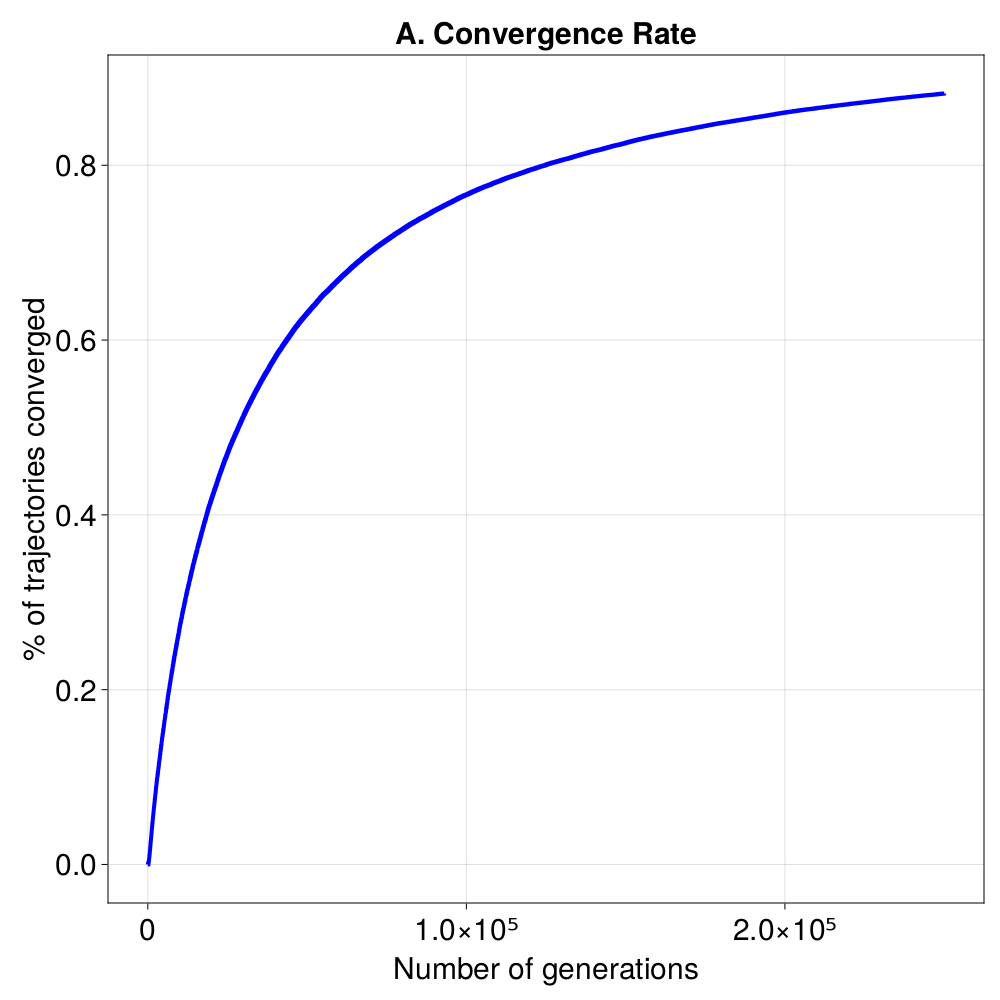

In [11]:
conv_time = map(x->sum(x),all_wait_times)

nconv = sum(all_conv)

fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 30.)

ax = Axis(fig[1,1])

plot_convergence_rate!(ax,conv_time,length(exp_versions)*n_trials,max_gen)

cond_save(plotsdirx(plot_save_dir,"ConvergenceRate.png"),fig,save_fig)

fig

In [12]:
fs_mss =  map(list_mss->select_minimal_topologies(list_mss),all_min_fs_networks)
ls_mss =  map(list_mss->select_minimal_topologies(list_mss),all_min_end_networks);

In [13]:
countmap(map(x->length(x),all_min_end_networks))

Dict{Int64, Int64} with 6 entries:
  5 => 4
  4 => 50
  6 => 2
  2 => 3593
  3 => 300
  1 => 101898

In [14]:
nconv

105847

In [15]:
mean(map(x->size(x,2),all_geno_traj))

10.617287216453938

In [16]:
# trajectories = map(n->Trajectory(n,all_geno_traj[n],all_fitness_traj[n],all_wait_times[n] .+ 1,all_mut_types[n],weight_names),1:nconv);

trajectories = map(n->Trajectory(n,all_geno_traj[n],all_fitness_traj[n],all_wait_times[n] .+ 1,all_mut_choices[n],all_mut_types[n],all_mut_sizes[n],weight_names),1:nconv);

for (n,tr) in enumerate(trajectories)
    assign_minimal_subgraphs!(tr,fs_mss[n],ls_mss[n])
end

inc_metagraph, vertex_top_map,top_vertex_map,vertex_complexity_map,inclusion_matrix = create_inclusion_metagraph(trajectories);

minimal_motif_id = findall(indegree(inc_metagraph) .== 0);

minimal_motifs = reduce(hcat,[vertex_top_map[vertex_id] for vertex_id in minimal_motif_id])

for tr in trajectories
    assign_inc_vertex_ids!(tr,top_vertex_map)
    assign_inc_parents!(tr,inclusion_matrix,vertex_complexity_map,minimal_motif_id)
end

In [283]:
# for tr in trajectories
#     evaluate_epistasis_types_shap!(tr,grn_parameters,DefaultGRNSolver(),fitness_function,mutation_op,1e-6)
# end

# save("epistasis_types_all_N6.jld2", "data",map(x->x.epistasis,trajectories))

In [704]:
# include(srcdirx("Epistasis.jl"))

# for tr in trajectories
#     evaluate_epistasis_types_full!(tr,grn_parameters,DefaultGRNSolver(),fitness_function,mutation_op)
# end

# save("epistasis_types_full_N6.jld2", "data",map(x->x.epistasis,trajectories))

In [715]:
epi_types_full = load("epistasis_types_full_N6.jld2","data")

for (tr,epi_type) in zip(trajectories,epi_types_full)
    tr.epistasis = epi_type
end

In [922]:
fitness_eps = 0.01
include(srcdirx("Epistasis.jl"))

for tr in trajectories_p
    cr_new = map(cr->characterise_epistasis(cr[2],fitness_eps),tr.epistasis)
    tr.epistasis = cr_new
end

In [18]:
for i in 1:length(all_mut_sizes)

    if all([length(t) == length(s) for (t,s) in zip(all_mut_types[i],all_mut_sizes[i])])
        nothing
    else
        print(i)
        print("\n")
    end
end

In [19]:
end_parents = map(tr->tr.inc_metagraph_vertices[end],trajectories)

sorted_uep,sorted_counts_uep = return_order_by_count(end_parents);

uep_position_dict = Dict(v=>n for (n,v) in enumerate(sorted_uep));

mst_conf_int = confint(MultinomialLRT(sorted_counts_uep),0.05)

sorted_uep_other = vcat(sorted_counts_uep[1:8],[sum(sorted_counts_uep[9:end])])

mst_conf_int_r = confint(MultinomialLRT(sorted_uep_other),0.05)

top_n = 4

4

In [20]:
length(sorted_uep)

732

In [21]:
entropy(sorted_counts_uep ./ sum(sorted_counts_uep))

0.4518383207450712

In [1500]:
a1 = sorted_counts_uep ./ sum(sorted_counts_uep)
mean(a1[9:end]) * 100

0.03420578864301527

In [23]:
color_scheme = Makie.wong_colors();

In [24]:
# embedding = umap(data["dmat_av"], 2; metric = :precomputed,n_neighbors = 50,min_dist = 0.5);

embedding = umap(all_mat_av_X, 2; metric = d_metric,n_neighbors = 50,min_dist = 0.5);

In [25]:
draw_config_18 = fs18_default();
draw_config_12 = fs12_default();

fontsize_pub = 12.;

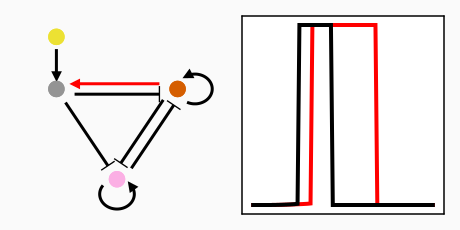

In [26]:
include(srcdirx("AnalysisVisualization.jl"))

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution =  (460,230),fontsize = fontsize_pub)

example_id = 12

twin_axis = true

plot_mst_explanation!(fig,trajectories,example_id,draw_config_18,fs18_default,node_colors,fontsize_pub,false,twin_axis)

cond_save(plotsdirx(plot_save_dir,"MSTExample_" * string(example_id) * ".png"),fig,true)

fig

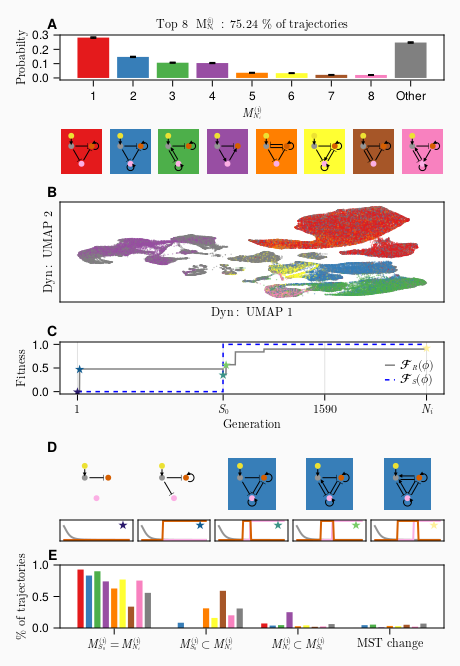

In [1492]:
include(srcdirx("AnalysisVisualization.jl"))

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (460,750-(7*12)),fontsize = fontsize_pub)

ds_config_12 = dynamical_summary_config(fontsize_pub,2.,ext_palette,node_colors,draw_config_12,1.5,12.,2.,1.,2.5,14.)

example_mst = 2

# tr_choice = StatsBase.sample(findall(tr->(length(tr.geno_traj) == 7) & (tr.H0 < 5),filter(tr->(tr.inc_metagraph_vertices[tr.H0] == sorted_uep[example_mst]),trajectories)))

tr_choice = 14168
# 14974

min_n = length(exp_versions)*300

plot_dynamical_summary_portrait!(fig,trajectories,embedding,8,min_n,sorted_uep,sorted_counts_uep,mst_conf_int_r,end_parents,vertex_top_map,example_mst,tr_choice,ds_config_12)

cond_save(plotsdirx(plot_save_dir,"DynamicalSummary_Extended_Sum.pdf"),fig,save_fig)

fig

In [28]:
development = DefaultGRNSolver()

const orig_network = trajectories[1].geno_traj[1]

founder = Individual(reshape(orig_network,(3,4)),grn_parameters,development)
orig_phenotype = founder.phenotype.u[end][3,:]

orig_phenotype = orig_phenotype ./ maximum(orig_phenotype);

In [173]:
# all_pheno = map(tr->map(g->new_phenotype(founder,reshape(g,(3,4)),development),tr.geno_traj),trajectories);
# save("all_pheno_N6.jld2", "data",all_pheno)

In [1072]:
include(srcdirx("PhenotypeEvaluation.jl"))

all_pheno_ch = map(tr_ph->map(ph->pheno_characterise(ph,lower_bound,upper_bound,min_width),tr_ph),all_pheno);

all_pheno_mut_ch = map(tr_ph->[characterise_mutation(ph1,ph2,1.01) for (ph1,ph2) in zip(tr_ph[1:end-1],tr_ph[2:end])],all_pheno_ch);

In [1086]:
S0_Pheno = [mc[1] for (mc,tr) in zip(all_pheno_mut_chf,trajectories)]

countmap(S0_Pheno)

Dict{Vector{Symbol}, Int64} with 5 entries:
  [:clb]     => 102834
  [:crb]     => 707
  [:other]   => 1097
  [:cbb]     => 517
  [:neutral] => 692

In [1074]:
countmap([mc[1] for mc in all_pheno_mut_ch])

Dict{Vector{Symbol}, Int64} with 5 entries:
  [:clb]     => 102834
  [:crb]     => 707
  [:cbb]     => 517
  [:grow]    => 1097
  [:neutral] => 692

In [1093]:
# replace_dict = Dict([:mlb, :crb_wlb]=>[:crb],
#                     [:clb_wrb,:mrb]=>[:clb],
#                     [:crb_wlb] => [:crb],
#                     [:clb_wrb] => [:clb],
#                     [:switch_lr] => [:other],
#                     [:switch_rl] => [:other],
#                     [:grow] => [:other],
#                     [:drb]=>[:other],
#                     [:dlb]=>[:other],
#                     [:nothing] => [:neutral]);

replace_dict = Dict([:mrb_wbb, :crb_wlb]=>[:crb_wlb],
                    [:mlb_wbb, :crb_wlb] => [:crb_wlb],
                    [:mrb_wbb] => [:mbb_wbb],
                    [:mlb_wbb] => [:mbb_wbb],
                    [:clb_wrb,:mrb_wbb]=>[:clb_wrb],
                    [:mlb_wbb, :mrb_wbb] => [:mbb_wbb],
                    [:switch_lr] => [:other],
                    [:switch_rl] => [:other],
                    [:grow] => [:other],
                    [:drb]=>[:other],
                    [:dlb]=>[:other],
                    [:nothing] => [:neutral]);


all_pheno_mut_chf = map(tr_ph->map(ph->haskey(replace_dict,ph) ? replace_dict[ph] : ph,tr_ph),all_pheno_mut_ch);

In [1082]:
countmap(reduce(vcat,all_pheno_mut_chf))

Dict{Vector{Symbol}, Int64} with 12 entries:
  [:mbb_wbb] => 251798
  [:mrb_wrb] => 2085
  [:cbb]     => 582
  [:crb]     => 827
  [:mrb_wbb] => 136336
  [:clb_wrb] => 1024
  [:other]   => 1588
  [:mlb_wbb] => 27179
  [:clb]     => 104490
  [:mlb_wlb] => 238925
  [:crb_wlb] => 104241
  [:neutral] => 148886

In [32]:
# countmap(reduce(vcat,all_pheno_mut_ch))

In [1150]:
dodge_gap = 0.03 #Makie default
gap = 0.2 #Makie default
width = 1 #Makie default

xerr = compute_x([1,2,3,4], width, gap, [1,2,3,4], dodge_gap)

4-element Vector{Float64}:
 0.6910000000000001
 1.897
 3.103
 4.309

In [1153]:
# include(srcdirx("AnalysisVisualization.jl"))
# # include(srcdirx("TrajectoryAnalysis.jl"))

# fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
#     resolution = (460,Int(floor(750/2)) - 3*12),fontsize = fontsize_pub)

# evo_config_12 = evo_summary_config(fontsize_pub,6.,1.,ext_palette,node_colors,draw_config_12,1.,4.,2.,epi_colors,0.5)

# create_epi_single_portrait_bar_v1!(fig,trajectories,mut_prob,all_pheno_mut_chf,:quantiles,evo_config_12)

# cond_save(plotsdirx(plot_save_dir,"ExtBarSingle_EpiSummary_v1.pdf"),fig,save_fig)

# fig

In [1155]:
mean_wait_type_labels = compute_x([1,2,3,4], width, gap, [1,2,3,4], dodge_gap)

4-element Vector{Float64}:
 0.6910000000000001
 1.897
 3.103
 4.309

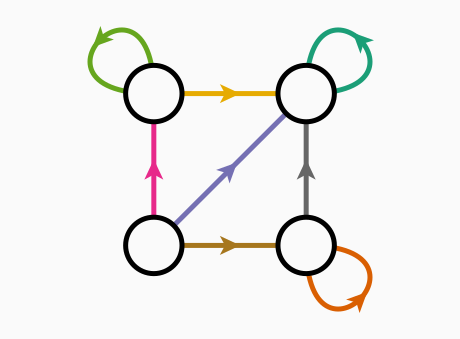

In [1196]:
include(srcdirx("AnalysisVisualization.jl"))

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
resolution = (460,Int(floor(750/2)) - 3*12),fontsize = fontsize_pub)

draw_comm_graph!(fig)

cond_save(plotsdirx(plot_save_dir,"CommPhenoGraph.pdf"),fig,save_fig)

fig

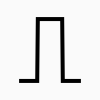

In [1341]:
initial_pheno = all_pheno[1][1]
left_boundary = vcat(zeros(30),ones(70))
right_boundary = vcat(ones(70),zeros(30))

stripe_thumb = vcat(zeros(30),ones(40),zeros(30))

pheno_ex_names = ["initial_pheno","left_boundary","right_boundary","stripe_pheno"]

for (n,pheno) in enumerate([initial_pheno,left_boundary,right_boundary,stripe_thumb])

    fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (100,100),fontsize = fontsize_pub)

    ax = Axis(fig[1,1],backgroundcolor = RGBf(0.98, 0.98, 0.98))

    CairoMakie.lines!(ax,pheno, color = :black, linewidth = 4.)

    hidedecorations!(ax)
    hidespines!(ax)

    cond_save(plotsdirx(plot_save_dir,pheno_ex_names[n] * ".pdf"),fig,save_fig)
end

fig

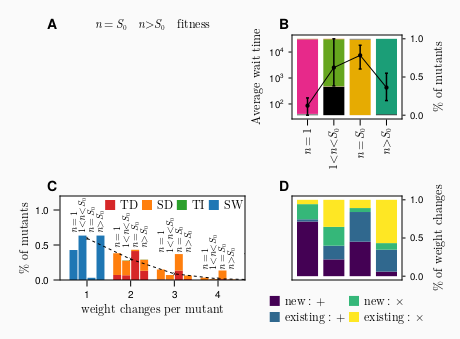

In [1495]:
include(srcdirx("AnalysisVisualization.jl"))
# include(srcdirx("TrajectoryAnalysis.jl"))

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (460,Int(floor(750/2)) - 3*12),fontsize = fontsize_pub)

evo_config_12 = evo_summary_config(fontsize_pub,6.,1.,ext_palette,node_colors,draw_config_12,1.,4.,2.,epi_colors,0.5)

create_epi_single_portrait_bar_v2!(fig,trajectories,mut_prob,all_pheno_mut_chf,:quantiles,evo_config_12,ds_config_12)

cond_save(plotsdirx(plot_save_dir,"ExtBarSingle_EpiSummary_v2.pdf"),fig,save_fig)

fig

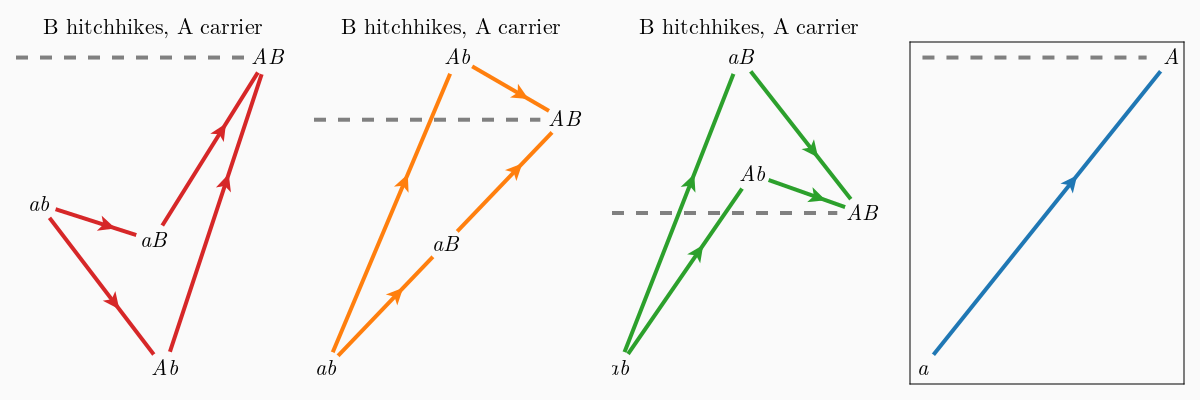

In [1446]:
# fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
#     resolution = (400,400),fontsize = fontsize_pub)

ab_fitness = 0.8
AB_fitness = 1.
aB_fitness = 1.2
Ab_fitness = 1.05

# ["ab","AB","aB","Ab"]

ti_fitness = [0.8,1.,1.2,1.05]
sd_fitness = [0.8,1.,0.9,1.05]
td_fitness = [0.92,1.,0.9,0.83]

epi_ex_names = ["TD","SD","TI","SIC"]

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
resolution = (1200,400),fontsize = 22.)

for (n,fitness_vec) in enumerate([td_fitness,sd_fitness,ti_fitness])

    ab_fitness = fitness_vec[1]
    AB_fitness = fitness_vec[2]
    aB_fitness = fitness_vec[3]
    Ab_fitness = fitness_vec[4]

    total_x = maximum([ab_fitness,AB_fitness,aB_fitness,AB_fitness]) - minimum([ab_fitness,AB_fitness,aB_fitness,AB_fitness]) 

    comm_points = [Point2f(0.,ab_fitness),Point2f(0.5*total_x,aB_fitness),Point2f(0.55*total_x,Ab_fitness),Point2f(total_x,AB_fitness)]

    adj_structure = [(1, 2),(1, 3),(2, 4),(3, 4)]

    adj_mat = zeros(4,4)

    for aij in adj_structure
        adj_mat[aij...] = 1
    end

    pin = Dict()

    for i in 1:4
        pin[i] = comm_points[i]
    end

    lw = 4.
    ns = 50.

    comm_graph = SimpleDiGraph(adj_mat)

    ax_comm = Axis(fig[1,n],backgroundcolor = RGBf(0.98, 0.98, 0.98),xlabelpadding=0.,ylabelpadding = 0., title = L"\text{B hitchhikes, A carrier}")

    graphplot!(ax_comm,comm_graph,layout = Spring(pin=pin, seed=11), edge_width = lw, node_size = ns,arrow_size = 25.,arrow_shift= 0.6, node_color = RGBf(0.98, 0.98, 0.98),edge_color = epi_colors[n])

    CairoMakie.text!(ax_comm,comm_points, text = [L"ab",L"aB",L"Ab",L"AB"], align = (:center,:center),fontsize = 22.)

    # CairoMakie.hlines!(AB_fitness, linestyle = :dash, color = :grey, linewidth = lw)

    CairoMakie.linesegments!(ax_comm,[(-0.01,AB_fitness),(0.9*total_x,AB_fitness)], linestyle = :dash, color = :grey, linewidth = lw)

    hidedecorations!(ax_comm)  # hides ticks, grid and lables

    CairoMakie.xlims!(ax_comm,-0.01,1.1*total_x)
    hidespines!(ax_comm)

    # pos_start = Point2f(0.,minimum([ab_fitness,AB_fitness,aB_fitness,AB_fitness]))
    # pos_end = Point2f(0.,maximum([ab_fitness,AB_fitness,aB_fitness,AB_fitness]))

    # dir_travel = pos_end - pos_start

    # CairoMakie.arrows!(ax_comm,[pos_start[1]],[pos_start[2]],[dir_travel[1]],[dir_travel[2]], color = :red, linewidth = lw,arrowsize = 20)

    # CairoMakie.text!(ax_comm,Point2f(0.01,1.075*AB_fitness), text = [L"\text{fitness}"], align = (:left, :top),rotation = pi/2, color = :red)

end

comm_points = [Point2f(0.,0.),Point2f(1.,1.)]

adj_structure = [(1, 2)]

adj_mat = zeros(2,2)

for aij in adj_structure
    adj_mat[aij...] = 1
end

pin = Dict()

for i in 1:2
    pin[i] = comm_points[i]
end

lw = 4.
ns = 50.

comm_graph = SimpleDiGraph(adj_mat)

ax_comm = Axis(fig[1,4],backgroundcolor = RGBf(0.98, 0.98, 0.98),xlabelpadding=0.,ylabelpadding = 0.)

graphplot!(ax_comm,comm_graph,layout = Spring(pin=pin, seed=11), edge_width = lw, node_size = ns,arrow_size = 25.,arrow_shift= 0.6, node_color = RGBf(0.98, 0.98, 0.98),edge_color = epi_colors[4])
CairoMakie.text!(ax_comm,comm_points, text = [L"a",L"A"], align = (:center,:center),fontsize = 22.)
CairoMakie.linesegments!(ax_comm,[(0.,1.),(0.9,1.)], linestyle = :dash, color = :grey, linewidth = lw)

hidedecorations!(ax_comm)

cond_save(plotsdirx(plot_save_dir,"epi_ex.pdf"),fig,save_fig)

fig

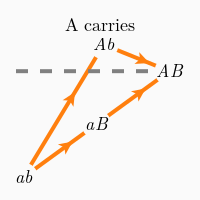

In [1471]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
resolution = (200,200),fontsize = 18.)

lw = 4.
ns = 42.
as = 20.

# n = 2

ab_fitness = sd_fitness[1]
AB_fitness = sd_fitness[2]
aB_fitness = sd_fitness[3]
Ab_fitness = sd_fitness[4]

total_x = maximum([ab_fitness,AB_fitness,aB_fitness,AB_fitness]) - minimum([ab_fitness,AB_fitness,aB_fitness,AB_fitness]) 

comm_points = [Point2f(0.,ab_fitness),Point2f(0.5*total_x,aB_fitness),Point2f(0.55*total_x,Ab_fitness),Point2f(total_x,AB_fitness)]

adj_structure = [(1, 2),(1, 3),(2, 4),(3, 4)]

adj_mat = zeros(4,4)

for aij in adj_structure
    adj_mat[aij...] = 1
end

pin = Dict()

for i in 1:4
    pin[i] = comm_points[i]
end

# lw = 4.
# ns = 50.

comm_graph = SimpleDiGraph(adj_mat)

ax_comm = Axis(fig[1,1],backgroundcolor = RGBf(0.98, 0.98, 0.98),xlabelpadding=0.,ylabelpadding = 0., title = L"\text{A carries}")

graphplot!(ax_comm,comm_graph,layout = Spring(pin=pin, seed=11), edge_width = lw, node_size = ns,arrow_size = as,arrow_shift= 0.6, node_color = RGBf(0.98, 0.98, 0.98),edge_color = epi_colors[n])

CairoMakie.text!(ax_comm,comm_points, text = [L"ab",L"aB",L"Ab",L"AB"], align = (:center,:center),fontsize = 18.)

# CairoMakie.hlines!(AB_fitness, linestyle = :dash, color = :grey, linewidth = lw)

CairoMakie.linesegments!(ax_comm,[(-0.01,AB_fitness),(0.9*total_x,AB_fitness)], linestyle = :dash, color = :grey, linewidth = lw)

hidedecorations!(ax_comm)  # hides ticks, grid and lables

CairoMakie.xlims!(ax_comm,-0.01,1.1*total_x)
hidespines!(ax_comm)

cond_save(plotsdirx(plot_save_dir,"epi_sd_small_c.pdf"),fig,save_fig)

fig

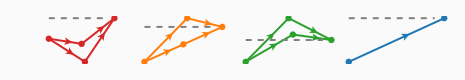

In [1371]:
# fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
#     resolution = (400,400),fontsize = fontsize_pub)

lw = 2.
ns = 9.
as = 12.

# ["ab","AB","aB","Ab"]

ti_fitness = [0.8,1.,1.2,1.05]
sd_fitness = [0.8,1.,0.9,1.05]
td_fitness = [0.92,1.,0.9,0.83]

epi_ex_names = ["TD","SD","TI","SIC"]

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
resolution = (465,80),fontsize = fontsize_pub)

for (n,fitness_vec) in enumerate([td_fitness,sd_fitness,ti_fitness])

    ab_fitness = fitness_vec[1]
    AB_fitness = fitness_vec[2]
    aB_fitness = fitness_vec[3]
    Ab_fitness = fitness_vec[4]

    total_x = maximum([ab_fitness,AB_fitness,aB_fitness,AB_fitness]) - minimum([ab_fitness,AB_fitness,aB_fitness,AB_fitness]) 

    comm_points = [Point2f(0.,ab_fitness),Point2f(0.5*total_x,aB_fitness),Point2f(0.55*total_x,Ab_fitness),Point2f(total_x,AB_fitness)]

    adj_structure = [(1, 2),(1, 3),(2, 4),(3, 4)]

    adj_mat = zeros(4,4)

    for aij in adj_structure
        adj_mat[aij...] = 1
    end

    pin = Dict()

    for i in 1:4
        pin[i] = comm_points[i]
    end

    comm_graph = SimpleDiGraph(adj_mat)

    ax_comm = Axis(fig[1,n],backgroundcolor = RGBf(0.98, 0.98, 0.98),xlabelpadding=0.,ylabelpadding = 0.)

    graphplot!(ax_comm,comm_graph,layout = Spring(pin=pin, seed=11), edge_width = lw, node_size = ns,arrow_size = as,arrow_shift= 0.6, node_color = epi_colors[n],edge_color = epi_colors[n])


    CairoMakie.linesegments!(ax_comm,[(0.,AB_fitness),(0.9*total_x,AB_fitness)], linestyle = :dash, color = :grey, linewidth = lw)

    hidedecorations!(ax_comm)  # hides ticks, grid and lables

    CairoMakie.xlims!(ax_comm,-0.05,1.1*total_x)

    hidespines!(ax_comm)

    # pos_start = Point2f(0.,minimum([ab_fitness,AB_fitness,aB_fitness,AB_fitness]))
    # pos_end = Point2f(0.,maximum([ab_fitness,AB_fitness,aB_fitness,AB_fitness]))

    # dir_travel = pos_end - pos_start

    # CairoMakie.arrows!(ax_comm,[pos_start[1]],[pos_start[2]],[dir_travel[1]],[dir_travel[2]], color = :red, linewidth = lw,arrowsize = 20)

    # CairoMakie.text!(ax_comm,Point2f(0.01,1.075*AB_fitness), text = [L"\text{fitness}"], align = (:left, :top),rotation = pi/2, color = :red)

end

comm_points = [Point2f(0.,0.),Point2f(1.,1.)]

adj_structure = [(1, 2)]

adj_mat = zeros(2,2)

for aij in adj_structure
    adj_mat[aij...] = 1
end

pin = Dict()

for i in 1:2
    pin[i] = comm_points[i]
end


comm_graph = SimpleDiGraph(adj_mat)

ax_comm = Axis(fig[1,4],backgroundcolor = RGBf(0.98, 0.98, 0.98),xlabelpadding=0.,ylabelpadding = 0.)

graphplot!(ax_comm,comm_graph,layout = Spring(pin=pin, seed=11), edge_width = lw, node_size = ns,arrow_size = as,arrow_shift= 0.6, node_color = epi_colors[4],edge_color = epi_colors[4])

CairoMakie.linesegments!(ax_comm,[(0.,1.),(0.9,1.)], linestyle = :dash, color = :grey, linewidth = lw)

hidedecorations!(ax_comm)
hidespines!(ax_comm)

cond_save(plotsdirx(plot_save_dir,"epi_ex_small.pdf"),fig,save_fig)

colgap!(fig.layout, Relative(0.01))

fig

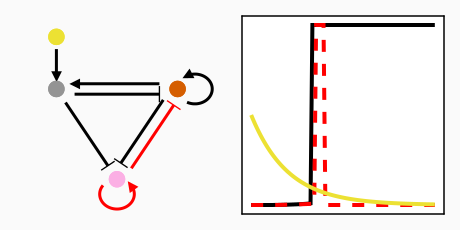

In [34]:
include(srcdirx("AnalysisVisualization.jl"))

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (460,230),fontsize = fontsize_pub)

plot_sf_explanation!(fig,trajectories,12,draw_config_18,fs18_default,node_colors,fontsize_pub,false,false)

cond_save(plotsdirx(plot_save_dir,"c_right_boundary_ex.pdf"),fig,save_fig)

fig

In [36]:
pop_equal_id = map(x->x.sim_id,filter(tr->tr.minimal_stripe_subgraphs[tr.H0] == tr.minimal_stripe_subgraphs[end], trajectories))

pop_H0_incl_N_id = map(x->x.sim_id,filter(tr->Bool(test_inclusion(tr.minimal_stripe_subgraphs[end],tr.minimal_stripe_subgraphs[tr.H0])) & !(tr.minimal_stripe_subgraphs[end] == tr.minimal_stripe_subgraphs[tr.H0]),trajectories))

pop_N_incl_H0_id = map(x->x.sim_id,filter(tr->Bool(test_inclusion(tr.minimal_stripe_subgraphs[tr.H0],tr.minimal_stripe_subgraphs[end])) & !(tr.minimal_stripe_subgraphs[end] == tr.minimal_stripe_subgraphs[tr.H0]),trajectories));

pop_incl = reduce(vcat,[pop_equal_id,pop_H0_incl_N_id,pop_N_incl_H0_id]);

pop_not_incl = map(tr->tr.sim_id,filter(tr->!(tr.sim_id ∈ pop_incl),trajectories));

@assert length(pop_not_incl) + length(pop_equal_id) + length(pop_H0_incl_N_id) + length(pop_N_incl_H0_id) == length(trajectories)

length(pop_not_incl) / length(trajectories)

0.03451207875518437

In [37]:
train_ttl = false
train_gtl = false

true

In [38]:
predict_id = sorted_uep[1:top_n]

label_names = 1:top_n |> collect

trajectories_p = copy(trajectories)

vertex_to_predict_label = Dict(vertex=>n for (n,vertex) in enumerate(predict_id))
predict_label_to_vertex = Dict(n=>vertex for (n,vertex) in enumerate(predict_id))
predict_label_to_vertex[top_n+1] = -1
labels = map(tr->tr.inc_metagraph_vertices[tr.H0] ∈ predict_id ? vertex_to_predict_label[tr.inc_metagraph_vertices[tr.H0]] : top_n + 1,trajectories_p);

const c_types = ["c" for _ in 1:10];

const predict_colors = vcat(ext_palette[1:top_n],[:grey]);

null_H0_dist = [count(x->x==i,labels) for i in 1:top_n+1] ./ length(trajectories_p);

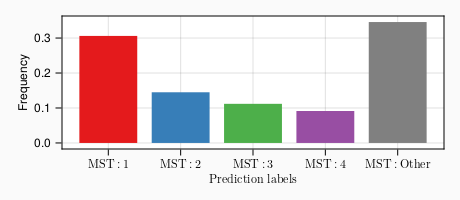

In [39]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (460,200),fontsize = fontsize_pub)

ax = Axis(fig[1,1],xlabel = L"\text{Prediction labels}", ylabel =  "Frequency")

CairoMakie.barplot!(ax,[1,2,3,4,5],null_H0_dist, color = predict_colors[1:5])

ax.xticks = (1:5,[L"\text{MST:1}",L"\text{MST:2}",L"\text{MST:3}",L"\text{MST:4}",L"\text{MST:Other}"])

cond_save(plotsdirx(plot_save_dir,"NullH0Dist.pdf"),fig,true)

fig

In [40]:
ac = "DN" * string(top_n)

"DN4"

In [41]:
if train_gtl || train_ttl
    train_id,test_id =  create_train_test_id_split(labels,0.8);
    save("train_test_ids_Other_" * ac * ".jld2", Dict("train" => train_id, "test" => test_id))
else
    train_id = load("train_test_ids_Other_" * ac * ".jld2", "train")
    test_id = load("train_test_ids_Other_" * ac * ".jld2", "test")
end;

In [42]:
X_train_ttl_v = [reduce(hcat,unique([vcat(features,label) for features in tr.topologies[1:tr.H0-1]])) for (label,tr) in zip(labels[train_id],trajectories_p[train_id])]
X_train_ttl = reduce(hcat,X_train_ttl_v) |> transpose |> collect

y_train_ttl = copy(Int.(X_train_ttl[:,13]))

X_train_gtl_v = [reduce(hcat,[vcat(features,label) for features in tr.geno_traj[1:tr.H0-1]]) for (label,tr) in zip(labels[train_id],trajectories_p[train_id])]
X_train_gtl  = reduce(hcat,X_train_gtl_v) |> transpose |> collect;

y_train_gtl = copy(Int.(X_train_gtl[:,13]))

###################

X_test_ttl_v = [reduce(hcat,unique([vcat(features,label) for features in tr.topologies[1:tr.H0-1]])) for (label,tr) in zip(labels[test_id],trajectories_p[test_id])]
X_test_ttl = reduce(hcat,X_test_ttl_v) |> transpose |> collect

y_test_ttl = copy(Int.(X_test_ttl[:,13]))

X_test_gtl_v = [reduce(hcat,[vcat(features,label) for features in tr.geno_traj[1:tr.H0-1]]) for (label,tr) in zip(labels[test_id],trajectories_p[test_id])]
X_test_gtl  = reduce(hcat,X_test_gtl_v) |> transpose |> collect;

y_test_gtl = copy(Int.(X_test_gtl[:,13]));

In [46]:
X_train_ttl_v_length = [reduce(hcat,[vcat(features,length(unique(tr.topologies[1:tr.H0-1]))) for features in unique(tr.topologies[1:tr.H0-1])]) for (label,tr) in zip(labels[train_id],trajectories_p[train_id])]
X_train_ttl_length  = reduce(hcat,X_train_ttl_v_length) |> transpose |> collect;

length_train_ttl = copy(Int.(X_train_ttl_length[:,13]));

X_train_gtl_v_length = [reduce(hcat,[vcat(features,tr.H0-1) for features in tr.geno_traj[1:tr.H0-1]]) for (label,tr) in zip(labels[train_id],trajectories_p[train_id])]
X_train_gtl_length  = reduce(hcat,X_train_gtl_v_length) |> transpose |> collect;

length_train_gtl = copy(Int.(X_train_gtl_length[:,13]));

In [44]:
for id in train_id
    trajectories_p[id].train_test_indicator = :train
end

for id in test_id
    trajectories_p[id].train_test_indicator = :test
end

## TTL - Train

In [61]:
if train_ttl

    params = Dict(
        "eta"=> 0.01,
        "objective"=>"multi:softprob",
        "num_class"=>top_n+1,
        "subsample"=> 0.5,
        "eval_metric"=>"auc"
    )

    max_boosting_rounds = 5000
    early_stop = 200

    d_train_ttl = xgboost.DMatrix(X_train_ttl[:,1:10], label=y_train_ttl .- 1,feature_names = weight_names)
    d_test_ttl = xgboost.DMatrix(X_test_ttl[:,1:10], label=y_test_ttl .- 1,feature_names = weight_names)

    model_ttl = xgboost.train(params, d_train_ttl, max_boosting_rounds, evals = [(d_test_ttl, "test")], verbose_eval=false, early_stopping_rounds=early_stop)

    ttl_prob_train = model_ttl.predict(d_train_ttl)
    ttl_prob_test = model_ttl.predict(d_test_ttl)

    y_pred_train_ttl = mapslices(x->argmax(x),ttl_prob_train,dims = 2)
    y_pred_test_ttl = mapslices(x->argmax(x),ttl_prob_test,dims = 2);

    print("Accuracy (test): " * string(sum(y_pred_test_ttl .== y_test_ttl) / length(y_test_ttl)))
    print("\n")

    all_bs_test = []

    for (n,p_row) in enumerate(eachrow(ttl_prob_test))
        push!(all_bs_test,brier_score(p_row,y_test_ttl[n]))
    end

    print("Brier score (test): " * string(mean(all_bs_test)))
    print("\n")

    all_bs_train = []

    for (n,p_row) in  enumerate(eachrow(ttl_prob_train))
        push!(all_bs_train,brier_score(p_row,y_train_ttl[n]))
    end

    print("Brier score (train): " * string(mean(all_bs_train)))
    print("\n")
    
    model_ttl.save_model("ModelTTL_Other_" * ac * ".json")

else
    model_ttl = xgboost.Booster()

    d_train_ttl = xgboost.DMatrix(X_train_ttl[:,1:10], label=y_train_ttl .- 1,feature_names = weight_names)
    d_test_ttl = xgboost.DMatrix(X_test_ttl[:,1:10], label=y_test_ttl .- 1,feature_names = weight_names)

    model_ttl.load_model("ModelTTL_Other_" * ac * ".json")

    ttl_prob_train = model_ttl.predict(d_train_ttl)
    ttl_prob_test = model_ttl.predict(d_test_ttl)

    y_pred_train_ttl = mapslices(x->argmax(x),ttl_prob_train,dims = 2)
    y_pred_test_ttl = mapslices(x->argmax(x),ttl_prob_test,dims = 2);
end;

Accuracy (test): 0.41975125004290764
Brier score (test): 0.1385281354116518
Brier score (train): 0.13800691950652422


## GTL - Train

In [62]:
if train_gtl

    params = Dict(
        "eta"=> 0.01,
        "objective"=>"multi:softprob",
        "num_class"=>top_n+1,
        "subsample"=> 0.5,
        "eval_metric"=>"auc"
    )

    max_boosting_rounds = 5000
    early_stop = 200

    d_train_gtl = xgboost.DMatrix(X_train_gtl[:,1:10], label=y_train_gtl .- 1,feature_names = weight_names)
    d_test_gtl = xgboost.DMatrix(X_test_gtl[:,1:10], label=y_test_gtl .- 1,feature_names = weight_names)

    model_gtl = xgboost.train(params, d_train_gtl, max_boosting_rounds, evals = [(d_test_gtl, "test")], verbose_eval=false, early_stopping_rounds=early_stop)

    gtl_prob_train = model_gtl.predict(d_train_gtl)
    gtl_prob_test = model_gtl.predict(d_test_gtl)

    y_pred_train_gtl = mapslices(x->argmax(x),gtl_prob_train,dims = 2)
    y_pred_test_gtl = mapslices(x->argmax(x),gtl_prob_test,dims = 2);

    print("Accuracy (test): " * string(sum(y_pred_test_gtl .== y_test_gtl) / length(y_test_gtl)))
    print("\n")

    all_bs_test = []

    for (n,p_row) in  enumerate(eachrow(gtl_prob_test))
        push!(all_bs_test,brier_score(p_row,y_test_gtl[n]))
    end

    print("Brier score (test): " * string(mean(all_bs_test)))
    print("\n")

    all_bs_train = []

    for (n,p_row) in  enumerate(eachrow(gtl_prob_train))
        push!(all_bs_train,brier_score(p_row,y_train_gtl[n]))
    end

    print("Brier score (train): " * string(mean(all_bs_train)))
    print("\n")

    model_gtl.save_model("ModelGTL_Other_" * ac * ".json")

else
    model_gtl = xgboost.Booster()

    d_train_gtl = xgboost.DMatrix(X_train_gtl[:,1:10], label=y_train_gtl .- 1,feature_names = weight_names)
    d_test_gtl = xgboost.DMatrix(X_test_gtl[:,1:10], label=y_test_gtl .- 1,feature_names = weight_names)

    model_gtl.load_model("ModelGTL_Other_" * ac * ".json")

    gtl_prob_train = model_gtl.predict(d_train_gtl)
    gtl_prob_test = model_gtl.predict(d_test_gtl)

    y_pred_train_gtl = mapslices(x->argmax(x),gtl_prob_train,dims = 2)
    y_pred_test_gtl = mapslices(x->argmax(x),gtl_prob_test,dims = 2);

end;

Accuracy (test): 0.5252274814258285
Brier score (test): 0.1194140347202528
Brier score (train): 0.11357657283824106


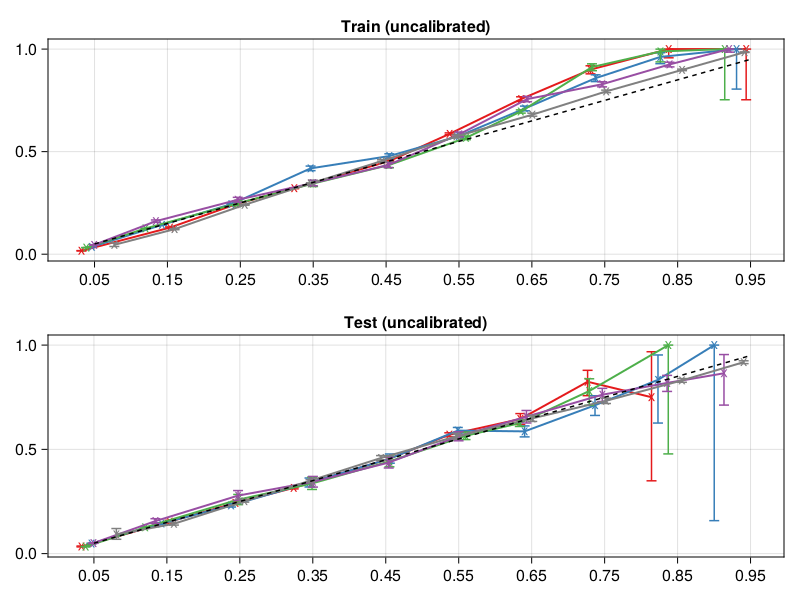

In [63]:
fig = CairoMakie.Figure(size = (800,800))

produce_prob_calibration_curve_binomial!(fig,y_train_gtl,gtl_prob_train,y_test_gtl,gtl_prob_test,predict_colors)

fig

In [64]:
for tr in trajectories_p
    # assign_predictions!(tr,model_ttl,:tt,predict_label_to_vertex)
    assign_predictions!(tr,model_gtl,:gt,predict_label_to_vertex)
end

for (tr,label) in zip(trajectories_p,labels)
    # assign_tt_other_prediction_errors!(tr,predict_label_to_vertex[label],predict_id)
    assign_gt_other_prediction_errors!(tr,predict_label_to_vertex[label],predict_id)
end

for tr in trajectories_p
    assign_weight_edits!(tr)
end

for tr in trajectories_p
    kl_div = [i == 1 ? StatsBase.kldivergence(tr.gt_label_probabilities[1,:],tr.gt_label_probabilities[i,:] .+ eps(),size(tr.gt_label_probabilities,2)) :  StatsBase.kldivergence(tr.gt_label_probabilities[i-1,:],tr.gt_label_probabilities[i,:] .+ eps(),size(tr.gt_label_probabilities,2)) for i in 1:size(tr.gt_label_probabilities,1)]
    tr.gt_kl_div = kl_div
end

In [341]:
# include(srcdirx("TrajectoryAnalysis.jl"))

# for tr in trajectories_p
#     assign_shap!(tr,model_gtl,:gt)
# end

# save("shap_contributions_N6.jld2", "data",map(x->x.other,trajectories_p))

In [958]:
all_epi = reduce(vcat,[tr.epistasis[1:tr.H0-2] for tr in trajectories_p])
# all_epi_id = reduce(vcat,[[tr.sim_id for i in 1:length(tr.epistasis[1:tr.H0-2])] for tr in trajectories_p])
all_shap = reduce(vcat,[[tr.other[n+1,:,tr.mutant_info[n].weight_id] for n in 1:tr.H0-2] for tr in trajectories_p])

# @assert length(all_epi) == length(all_shap)

se_2mut_id = findall(x->(x[1] == :se) & (length(x[2]) == 4), all_epi);
rse_2mut_id = findall(x->(x[1] == :rse) & (length(x[2]) == 4), all_epi);

In [962]:
# shap_m = abs.(reduce(hcat,map(x->[x[argmax(abs.(x[:,1])),1],x[argmax(abs.(x[:,2])),2]],all_shap[se_2mut_id])))

shap_m_se = abs.(reduce(vcat,map(x->sum(abs.(x),dims = 1),all_shap[se_2mut_id]))) |> transpose |> collect
shap_m_rse = abs.(reduce(vcat,map(x->sum(abs.(x),dims = 1),all_shap[rse_2mut_id]))) |> transpose |> collect;

In [960]:
epi_m_rse = reduce(hcat,map(x->x[2][2:3],all_epi[rse_2mut_id])) 
epi_m_se = reduce(hcat,map(x->x[2][2:3],all_epi[se_2mut_id])) 

epi_c_se = epi_m_se .> 1 - fitness_eps

epi_c_rse = [all(epi_m_rse[:,n] .== maximum(epi_m[:,n])) ? [true,false] : epi_m_rse[:,n] .== maximum(epi_m_rse[:,n]) for n  in 1:size(epi_m_rse,2)];

epi_c_rse = reduce(hcat,epi_c_rse)

deleterious = [epi_m_se[.!epi_c_se[:,n],n][1] < 0 for n in 1:size(epi_m_se,2)];

In [946]:
sum(epi_c)

33772

In [963]:
epi_ratio_se = reduce(vcat,[shap_m_se[epi_c_se[:,n],n] ./ shap_m_se[.!epi_c_se[:,n],n] for n in 1:size(epi_c_se,2)]);
epi_ratio_rse = reduce(vcat,[shap_m_rse[epi_c_rse[:,n],n] ./ shap_m_rse[.!epi_c_rse[:,n],n] for n in 1:size(epi_c_rse,2)]);

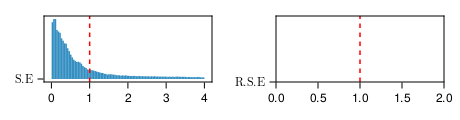

In [1429]:
fig = CairoMakie.Figure(resolution = (460,120),fontsize = 12.)
ax1 = Axis(fig[1,1], xgridvisible = false,ygridvisible = false)
ax2 = Axis(fig[1,2], xgridvisible = false,ygridvisible = false)

# CairoMakie.boxplot!(ax,.! deleterious,epi_ratio, show_outliers = false,orientation=:horizontal)

# CairoMakie.boxplot!(ax1,[1 for i in epi_ratio_se],epi_ratio_se, show_outliers = false,orientation=:horizontal)
# CairoMakie.boxplot!(ax2,[1 for i in epi_ratio_rse],epi_ratio_rse, show_outliers = false,orientation=:horizontal)

# CairoMakie.hist!(ax, filter(x->x < 4,epi_ratio[.!deleterious]), offset=0, direction=:y, bins = 100)
CairoMakie.hist!(ax1, filter(x->x < 4,epi_ratio_se), bins = 100,normalization = :pdf)

# CairoMakie.hlines!(ax,1., color = :red, linestyle = :dash)

CairoMakie.vlines!(ax1,1., color = :red, linestyle = :dash)
CairoMakie.vlines!(ax2,1., color = :red, linestyle = :dash)

ax1.yticks = (0:0,[L"\text{S.E}"])
ax2.yticks = (0:0,[L"\text{R.S.E}"])

fig

In [ ]:
# in general, how do these look for single mutation, rse etc

In [73]:
test_traj = findall(tr->tr.train_test_indicator == :test,trajectories_p);

streak = [find_streak(tr,:tedit) for (tr,l) in zip(trajectories_p[test_traj],labels[test_traj])];
label_streak = labels[test_traj];

sum(streak .== 1)/length(streak)

0.3247839025081479

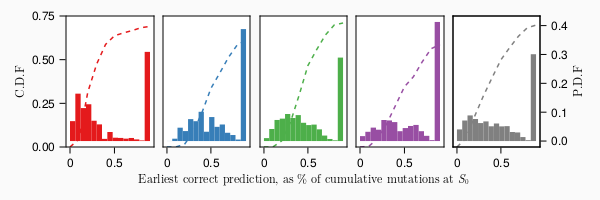

In [77]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (600,200),fontsize = fontsize_pub)

fig_n = fig[1,1] = GridLayout()

create_pred_accuracy_fig!(fig_n,streak,label_streak,predict_colors,top_n)

fig

In [68]:
# example_mst = 4
# tr_choice = 3404

# tr_data = filter(tr->tr.inc_metagraph_vertices[tr.H0] ∈ sorted_uep[example_mst],trajectories_p);

# example_traj = tr_data[tr_choice];

# ft = example_traj.fitness_traj_tuple[1:example_traj.H0]
# tr_traj = example_traj.topologies[1:example_traj.H0]
# tr_networks = example_traj.geno_traj[1:example_traj.H0]

# tr_we = example_traj.weight_edits[1:example_traj.H0]    
# tr_te = example_traj.top_edits[1:example_traj.H0]    

# tr_prob = vcat(example_traj.gt_label_probabilities[1:example_traj.H0-1,:],reshape([i == example_mst ? 1. : 0. for i in 1:5],(1,5)))
# tr_ent = vcat(example_traj.gt_label_entropies[1:example_traj.H0-1],[0.])

# tr_cr_ent = [i == 1 ? StatsBase.crossentropy(tr_prob[1,:],tr_prob[i,:],size(tr_prob,2)) : StatsBase.crossentropy(tr_prob[i-1,:],tr_prob[i,:],size(tr_prob,2)) for i in 1:size(tr_prob,1)]


In [69]:
# fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
#     resolution = (460,floor(750/4)),fontsize = fontsize_pub)

# n_networks = length(tr_networks)

# ax_prob_list = []

# for (i,n) in enumerate(tr_networks)

#     annotations = string.(round.(reshape(n,(3,4)),digits = 2))

#     if i == n_networks
#         ax_geno = Axis(fig[3:4,i], backgroundcolor = (predict_colors[example_mst],ds_config_12.color_fade),aspect = DataAspect())
#     else
#         ax_geno = Axis(fig[3:4,i], backgroundcolor = RGBf(0.98, 0.98, 0.98),aspect = DataAspect())
#     end

#     draw_grn!(ax_geno,n,ds_config_12.draw_config,ds_config_12.node_colors,ds_config_12.fontsize,annotations,false,false)

# end

# ax_prob = Axis(fig[1:2,1:n_networks])
# ax_pro = Axis(fig[1:2,1:n_networks],yaxisposition = :right, yticklabelcolor = :green)

# hidespines!(ax_pro)
# hideydecorations!(ax_pro,label = false,ticklabels = false,ticks = false,minorticks = false)
# hidexdecorations!(ax_pro)

# px = reduce(vcat,[[n for i in 1:size(tr_prob,2)] for n in 1:size(tr_prob,1)])
# pgrp = reduce(vcat,[[i for i in 1:size(tr_prob,2)] for n in 1:size(tr_prob,1)])

# CairoMakie.barplot!(ax_prob,px,vec(tr_prob |> transpose |> collect),color = [predict_colors[i] for i in pgrp], dodge = pgrp, gap = 0.55)

# ent_l = CairoMakie.lines!(ax_prob,tr_ent)
# ent_s = CairoMakie.scatter!(ax_prob,tr_ent, marker = 'x')

# we_l = CairoMakie.lines!(ax_pro,tr_we, color = :green)
# we_s = CairoMakie.scatter!(ax_pro,tr_we, marker = 'x', color = :green)

# te_l = CairoMakie.lines!(ax_pro,tr_te, color = :green, linestyle = "--")
# te_s = CairoMakie.scatter!(ax_pro,tr_te, marker = 'x', color = :green)

# rowgap!(fig.layout, Relative(0.01))
# colgap!(fig.layout, Relative(0.01))

# ax_prob.xticks = (1:5,[L"p^{(i)}(1)",L"p^{(i)}(S_0-3)",L"p^{(i)}(S_0-2)",L"p^{(i)}(S_0-1)",L"p^{(i)}(S_0)"])

# linkxaxes!(ax_pro,ax_prob)

# fig

In [78]:
contingency_data = Dict()

Dict{Any, Any}()

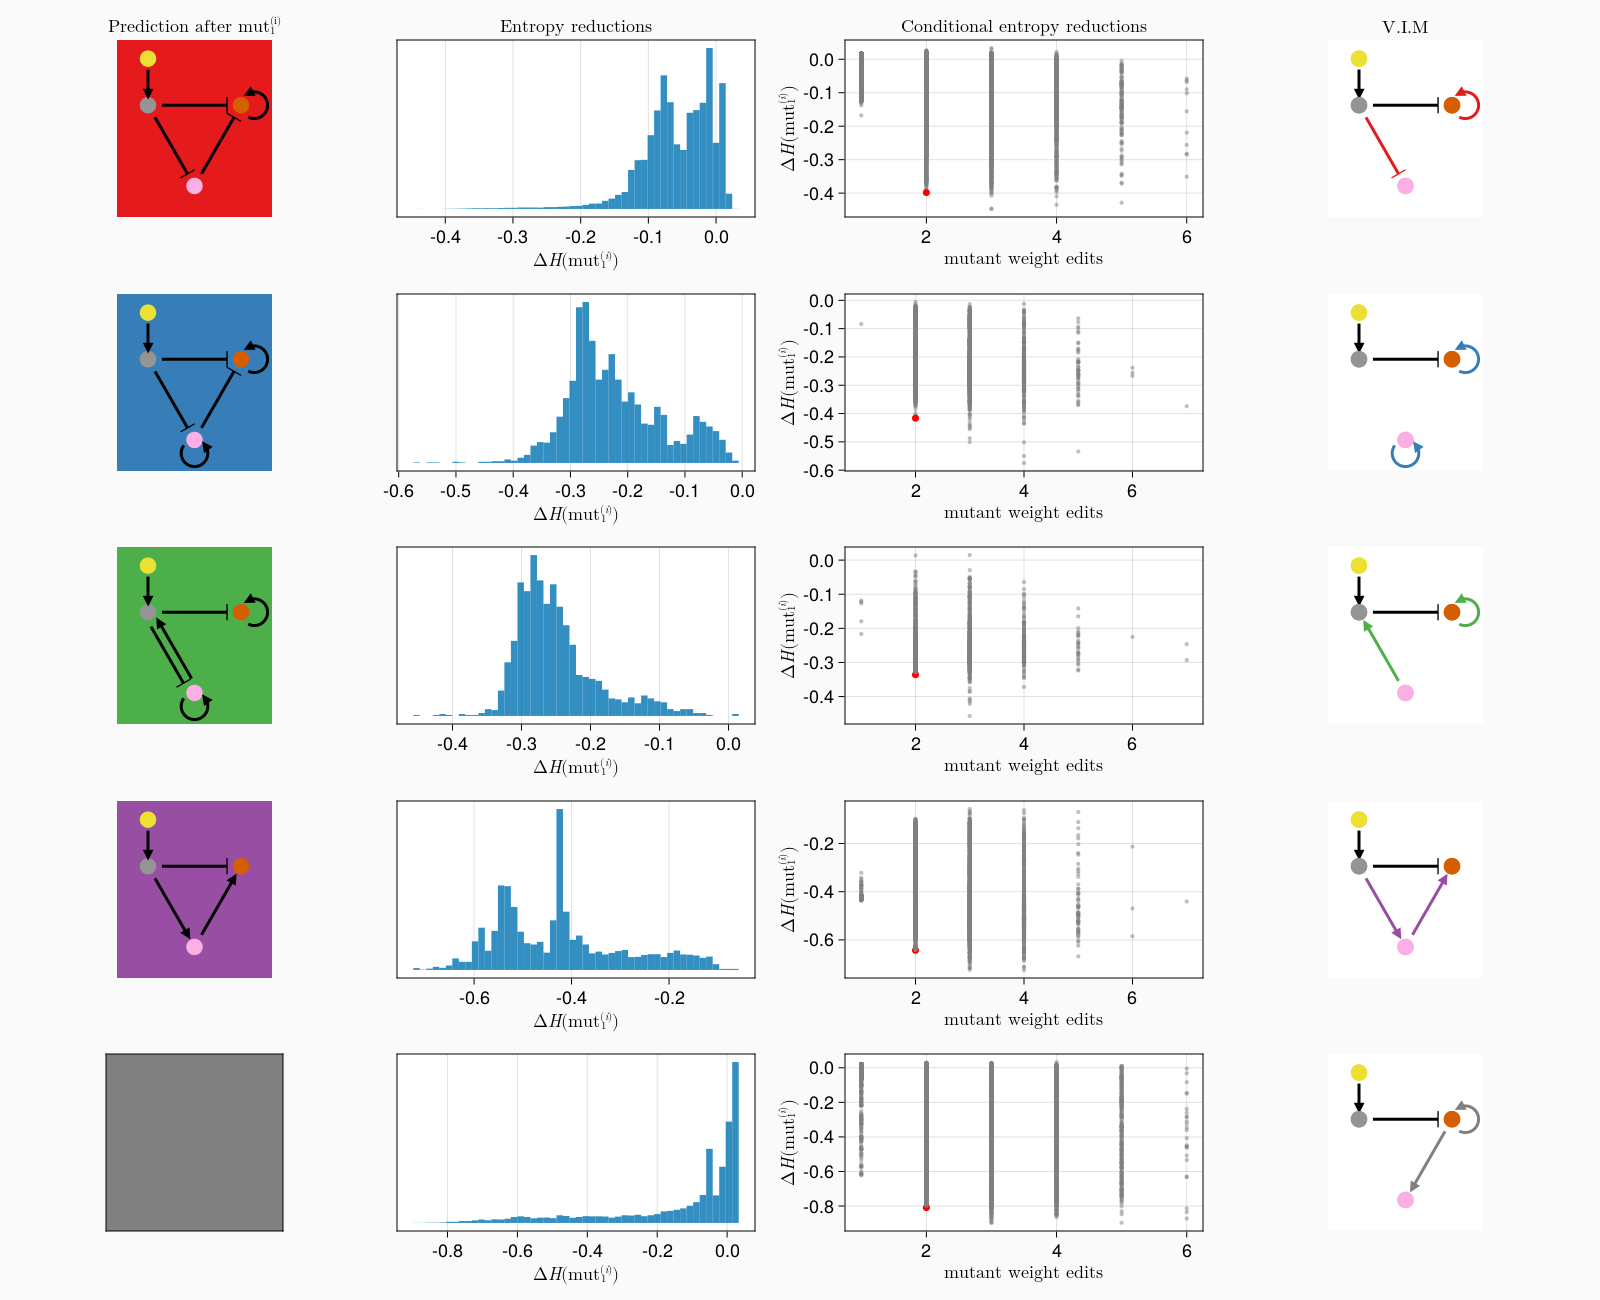

In [79]:
mut_n = 1
n_weight = 2

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
resolution = (1600, 1300),fontsize = 18.)

all_target_mutants = []
all_target_networks = []
all_target_prob = []
all_target_ent_deltas = []
all_target_max_ent = []

for n in 1:top_n+1

    if n == 1
        ax_geno = Axis(fig[n,1],backgroundcolor = (predict_colors[n],1.), title = L"\text{Prediction after \text{mut}^{(i)}_{1}}",aspect = DataAspect())

        ax_h = Axis(fig[n,2], title = L"\text{Entropy reductions}", xlabel = L"\Delta H(\text{mut}^{(i)}_{1})")
        ax_s = Axis(fig[n,3], title = L"\text{Conditional entropy reductions}", xlabel = L"\text{mutant weight edits}",ylabel = L"\Delta H(\text{mut}^{(i)}_{1})")

        ax_geno_m = Axis(fig[n,4], title = L"\text{V.I.M}",aspect = DataAspect())
    else
        ax_geno = Axis(fig[n,1],backgroundcolor = (predict_colors[n],1.),aspect = DataAspect())

        ax_h = Axis(fig[n,2], xlabel = L"\Delta H(\text{mut}^{(i)}_{1})")
        ax_s = Axis(fig[n,3], xlabel = L"\text{mutant weight edits}",ylabel = L"\Delta H(\text{mut}^{(i)}_{1})")

        ax_geno_m = Axis(fig[n,4],aspect = DataAspect())
    end

    if n == top_n+1
        sample = filter(tr->tr.gt_label_predictions[mut_n+1] == -1 ,trajectories_p)
    else
        sample = filter(tr->tr.gt_label_predictions[mut_n+1] == sorted_uep[n],trajectories_p)
    end

    # sample = filter(tr->(tr.gt_label_predictions[mut_n+1] ∈ sorted_uep[n]) & (tr.train_test_indicator == :test) ,trajectories_p)

    sample_entropy_deltas = map(tr->tr.gt_label_entropies[2:end] .- tr.gt_label_entropies[1:end-1],sample);
    sample_top_edits_deltas = map(tr->tr.weight_edits[2:end] .- tr.weight_edits[1:end-1],sample)

    sample_start_networks = map(tr->tr.geno_traj[mut_n],sample)
    sample_resultant_networks = map(tr->tr.geno_traj[mut_n+1],sample)

    sample_mutations = map(tr->tr.mutant_info[mut_n],sample)

    sample_probabilities = map(tr->tr.gt_label_probabilities[mut_n+1,:],sample)

    sample_top_edits_delta_select = map(x->x[mut_n],sample_top_edits_deltas);

    sample_entropy_delta_select = map(x->x[mut_n],sample_entropy_deltas);

    max_ent_delta = minimum(sample_entropy_delta_select[findall(sample_top_edits_delta_select .== n_weight)])

    target_mutant_id = findall(sample_top_edits_delta_select .== n_weight) ∩ findall(sample_entropy_delta_select .== max_ent_delta)

    target_mutant = sample_mutations[target_mutant_id[1]]

    target_prob = sample_probabilities[target_mutant_id[1]]

    push!(all_target_mutants,target_mutant)
    push!(all_target_prob,target_prob)
    push!(all_target_max_ent,max_ent_delta)
    push!(all_target_ent_deltas,sample_entropy_delta_select[findall(sample_top_edits_delta_select .== n_weight)])

    start_network = sample_start_networks[target_mutant_id[1]]
    resultant_network = sample_resultant_networks[target_mutant_id[1]]

    push!(all_target_networks,(start_network,resultant_network))

    CairoMakie.hist!(ax_h,sample_entropy_delta_select ,bins = 50, normalization = :pdf)

    CairoMakie.scatter!(ax_s,sample_top_edits_delta_select,sample_entropy_delta_select ,markersize =  [i == target_mutant_id[1] ? 10. : 6. for i in 1:length(sample_entropy_delta_select)], color = [i == target_mutant_id[1] ? :red : (:grey,0.5) for i in 1:length(sample_entropy_delta_select)])

    if n != top_n+1
        draw_grn!(ax_geno,vertex_top_map[sorted_uep[n]],draw_config_18,node_colors,18,false,false)
    else
        hidedecorations!(ax_geno)
    end

    draw_grn_mutant!(ax_geno_m,start_network,resultant_network,draw_config_18,fs18_default,node_colors,18.,predict_colors[n],false,false)

    hideydecorations!(ax_h)

end

fig

In [80]:
# [0.0 0.0 0.0 1.2490335893436255; -1.7574707655694604 0.0 0.0 0.0; -0.21577059555519695 0.0 0.8867674599052598 0.0]
# [0.0 0.0 0.0 1.2490335893436255; 0.0 1.987034531358056 0.0 0.0; -0.21577059555519695 0.0 2.3162108144754048 0.0]
# [0.0 2.2881326859196505 0.0 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.21577059555519695 0.0 1.8680307702243464 0.0]
# [0.0 0.0 0.0 1.2490335893436255; 2.382718773230891 0.0 0.0 0.0; -0.21577059555519695 1.5666679082774881 0.0 0.0]
# [0.0 0.0 0.0 1.2490335893436255; 0.0 0.0 2.5103478391869314 0.0; -0.21577059555519695 0.0 2.3492786163379145 0.0]

test_networks = map(x->reshape(x[2],(3,4)), all_target_networks)

5-element Vector{Matrix{Float64}}:
 [0.0 0.0 0.0 1.2490335893436255; -1.7574707655694604 0.0 0.0 0.0; -0.21577059555519695 0.0 0.8867674599052598 0.0]
 [0.0 0.0 0.0 1.2490335893436255; 0.0 1.987034531358056 0.0 0.0; -0.21577059555519695 0.0 2.3162108144754048 0.0]
 [0.0 2.2881326859196505 0.0 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.21577059555519695 0.0 1.8680307702243464 0.0]
 [0.0 0.0 0.0 1.2490335893436255; 2.382718773230891 0.0 0.0 0.0; -0.21577059555519695 1.5666679082774881 0.0 0.0]
 [0.0 0.0 0.0 1.2490335893436255; 0.0 0.0 2.5103478391869314 0.0; -0.21577059555519695 0.0 2.3492786163379145 0.0]

In [81]:
test_networks_top = map(x->Int.(sign.(x)), test_networks)

5-element Vector{Matrix{Int64}}:
 [0 0 0 1; -1 0 0 0; -1 0 1 0]
 [0 0 0 1; 0 1 0 0; -1 0 1 0]
 [0 1 0 1; 0 0 0 0; -1 0 1 0]
 [0 0 0 1; 1 0 0 0; -1 1 0 0]
 [0 0 0 1; 0 0 1 0; -1 0 1 0]

In [85]:
predict_mst = [vertex_top_map[id] for id in predict_id];
predict_mst_complexity = [sum(abs.(v)) for v in predict_mst];

In [1377]:
all_top_msn = []

all_top_msn_counts = []

vim_trajectories = []
vim_vertex_top_map = []

for n in 1:top_n+1

    data_con = load(datadirx("exp_pro/DeNovoStripe/Contingencies/RE_Minimal_Inhibiting_DN_Contingent_" * string(n) * "_RawData.jld2"));

    conv_con = copy(data_con["converged"]);

    print("MST: " * string(n) * " - " * string(sum(conv_con)/length(conv_con)))
    print("\n")
    
    nconv_con = sum(conv_con)

    fs_mss_con =  map(list_mss->select_minimal_topologies(list_mss),data_con["min_fs_networks"])
    ls_mss_con =  map(list_mss->select_minimal_topologies(list_mss),data_con["min_end_networks"]);

    trajectories_con = map(k->Trajectory(k,data_con["geno_traj"][conv_con][k],data_con["fitness_traj"][conv_con][k],data_con["wait_times"][conv_con][k] .+ 1,data_con["mut_choices"][conv_con][k],data_con["mut_type"][conv_con][k],data_con["mut_sizes"][conv_con][k],weight_names),1:nconv_con);

    for (nt,tr) in enumerate(trajectories_con)
        assign_minimal_subgraphs!(tr,fs_mss_con[nt],ls_mss_con[nt])
    end

    inc_metagraph_con, vertex_top_map_con,top_vertex_map_con,vertex_complexity_map_con,inclusion_matrix_con = create_inclusion_metagraph(trajectories_con);

    minimal_motif_id_con = findall(indegree(inc_metagraph_con) .== 0);

    minimal_motifs_con = reduce(hcat,[vertex_top_map_con[vertex_id] for vertex_id in minimal_motif_id_con]);

    for tr in trajectories_con
        tr.inc_metagraph_vertices = create_label_H0(tr,top_vertex_map,predict_id,predict_mst)
        tr.inc_metagraph_parents = create_label_H0_parent(tr,top_vertex_map,predict_id,predict_mst,predict_mst_complexity)
    end

    push!(vim_trajectories,trajectories_con)
    push!(vim_vertex_top_map,vertex_top_map_con)

end

contingency_data["Double"] = [all_target_networks,all_target_prob,vim_trajectories,all_target_ent_deltas,all_target_max_ent,all_target_mutants];

MST: 1 - 1.0
MST: 2 - 0.964
MST: 3 - 0.6882
MST: 4 - 0.9856
MST: 5 - 0.732


In [1379]:
all_top_msn = []

all_top_msn_counts = []

vim_trajectories = []
vim_vertex_top_map = []

for n in 1:top_n+1

    data_con = load(datadirx("exp_pro/DeNovoStripe/Contingencies/RE_Minimal_Inhibiting_DN_ContingentOS_" * string(n) * "_RawData.jld2"));

    conv_con = copy(data_con["converged"]);

    print("MST: " * string(n) * " - " * string(sum(conv_con)/length(conv_con)))
    print("\n")
    
    nconv_con = sum(conv_con)

    fs_mss_con =  map(list_mss->select_minimal_topologies(list_mss),data_con["min_fs_networks"])
    ls_mss_con =  map(list_mss->select_minimal_topologies(list_mss),data_con["min_end_networks"]);

    trajectories_con = map(k->Trajectory(k,data_con["geno_traj"][conv_con][k],data_con["fitness_traj"][conv_con][k],data_con["wait_times"][conv_con][k] .+ 1,data_con["mut_choices"][conv_con][k],data_con["mut_type"][conv_con][k],data_con["mut_sizes"][conv_con][k],weight_names),1:nconv_con);

    for (nt,tr) in enumerate(trajectories_con)
        assign_minimal_subgraphs!(tr,fs_mss_con[nt],ls_mss_con[nt])
    end

    inc_metagraph_con, vertex_top_map_con,top_vertex_map_con,vertex_complexity_map_con,inclusion_matrix_con = create_inclusion_metagraph(trajectories_con);

    minimal_motif_id_con = findall(indegree(inc_metagraph_con) .== 0);

    minimal_motifs_con = reduce(hcat,[vertex_top_map_con[vertex_id] for vertex_id in minimal_motif_id_con]);

    for tr in trajectories_con
        tr.inc_metagraph_vertices = create_label_H0(tr,top_vertex_map,predict_id,predict_mst)
        tr.inc_metagraph_parents = create_label_H0_parent(tr,top_vertex_map,predict_id,predict_mst,predict_mst_complexity)
    end

    push!(vim_trajectories,trajectories_con)
    push!(vim_vertex_top_map,vertex_top_map_con)

end

contingency_data["Single"] = [vim_trajectories];

MST: 1 - 0.9932
MST: 2 - 0.9128
MST: 3 - 0.9356
MST: 4 - 0.979
MST: 5 - 0.7042


In [86]:
founder_fitness = fitness_function(founder.phenotype)

(-1.0, 0.001483405426542828)

In [88]:
test_indices = Tuple.(findall(x->x>0,viable_mutations));

N_sample = 100

sample_points = LinRange(-max_w, max_w, N_sample);

In [89]:
# fitness_grid,pred_grid,entropy_grid,prob_grid = create_pairwise_fitness_landscape(founder,development,model_gtl,test_indices,N_sample,sample_points)

# save("grid_data_" * ac * ".jld2", Dict("fitness" => fitness_grid, "pred"=>pred_grid,"prob"=>prob_grid,"entropy"=>entropy_grid))

In [63]:
fitness_grid = load("grid_data.jld2","fitness")
pred_grid  = load("grid_data.jld2","pred")
entropy_grid  = load("grid_data.jld2","entropy")
prob_grid = load("grid_data.jld2","prob");

In [172]:
# fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
#     resolution = (460,750-7*12),fontsize = fontsize_pub)

# contin_target = [4,3,1,2,5]

# include(srcdirx("AnalysisVisualization.jl"))

# create_full_prediction_summary_nr!(fig,trajectories_p,sorted_uep,top_n,predict_colors,sample_points,ds_config_12)

# cond_save(plotsdirx(plot_save_dir,"Fig4_prediction2.pdf"),fig,true)

In [157]:
include(srcdirx("AnalysisVisualization.jl"))
include(srcdirx("PredictionFitnessLandscapes.jl"))

contin_target = [4,3,1,2,5]

test_indices = Tuple.(findall(x->x>0,viable_mutations));

min_prob = 1e-4

contin_choices,contin_prob = find_candidates(founder,all_target_networks,contin_target,top_n,model_gtl,test_indices,pred_grid,prob_grid,fitness_grid,sample_points,min_prob);

In [159]:
[a for a in contin_choices]

5-element Vector{Matrix{Float64}}:
 [0.0 0.0 0.0 1.2490335893436255; 1.5151515151515156 0.0 0.0 0.0; -0.21577059555519695 0.0 0.9090909090909083 0.0]
 [0.0 0.0 0.0 1.2490335893436255; 0.0 3.5353535353535364 0.0 0.0; -0.21577059555519695 0.0 0.7070707070707076 0.0]
 [0.0 -0.10101010101010033 0.0 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.21577059555519695 0.0 0.9090909090909083 0.0]
 [0.0 0.0 0.0 1.2490335893436255; -1.5151515151515147 0.0 0.0 0.0; -0.21577059555519695 -0.10101010101010033 0.0 0.0]
 [0.0 0.0 0.0 1.2490335893436255; 0.0 0.0 2.525252525252526 0.0; -0.21577059555519695 0.0 2.7272727272727266 0.0]

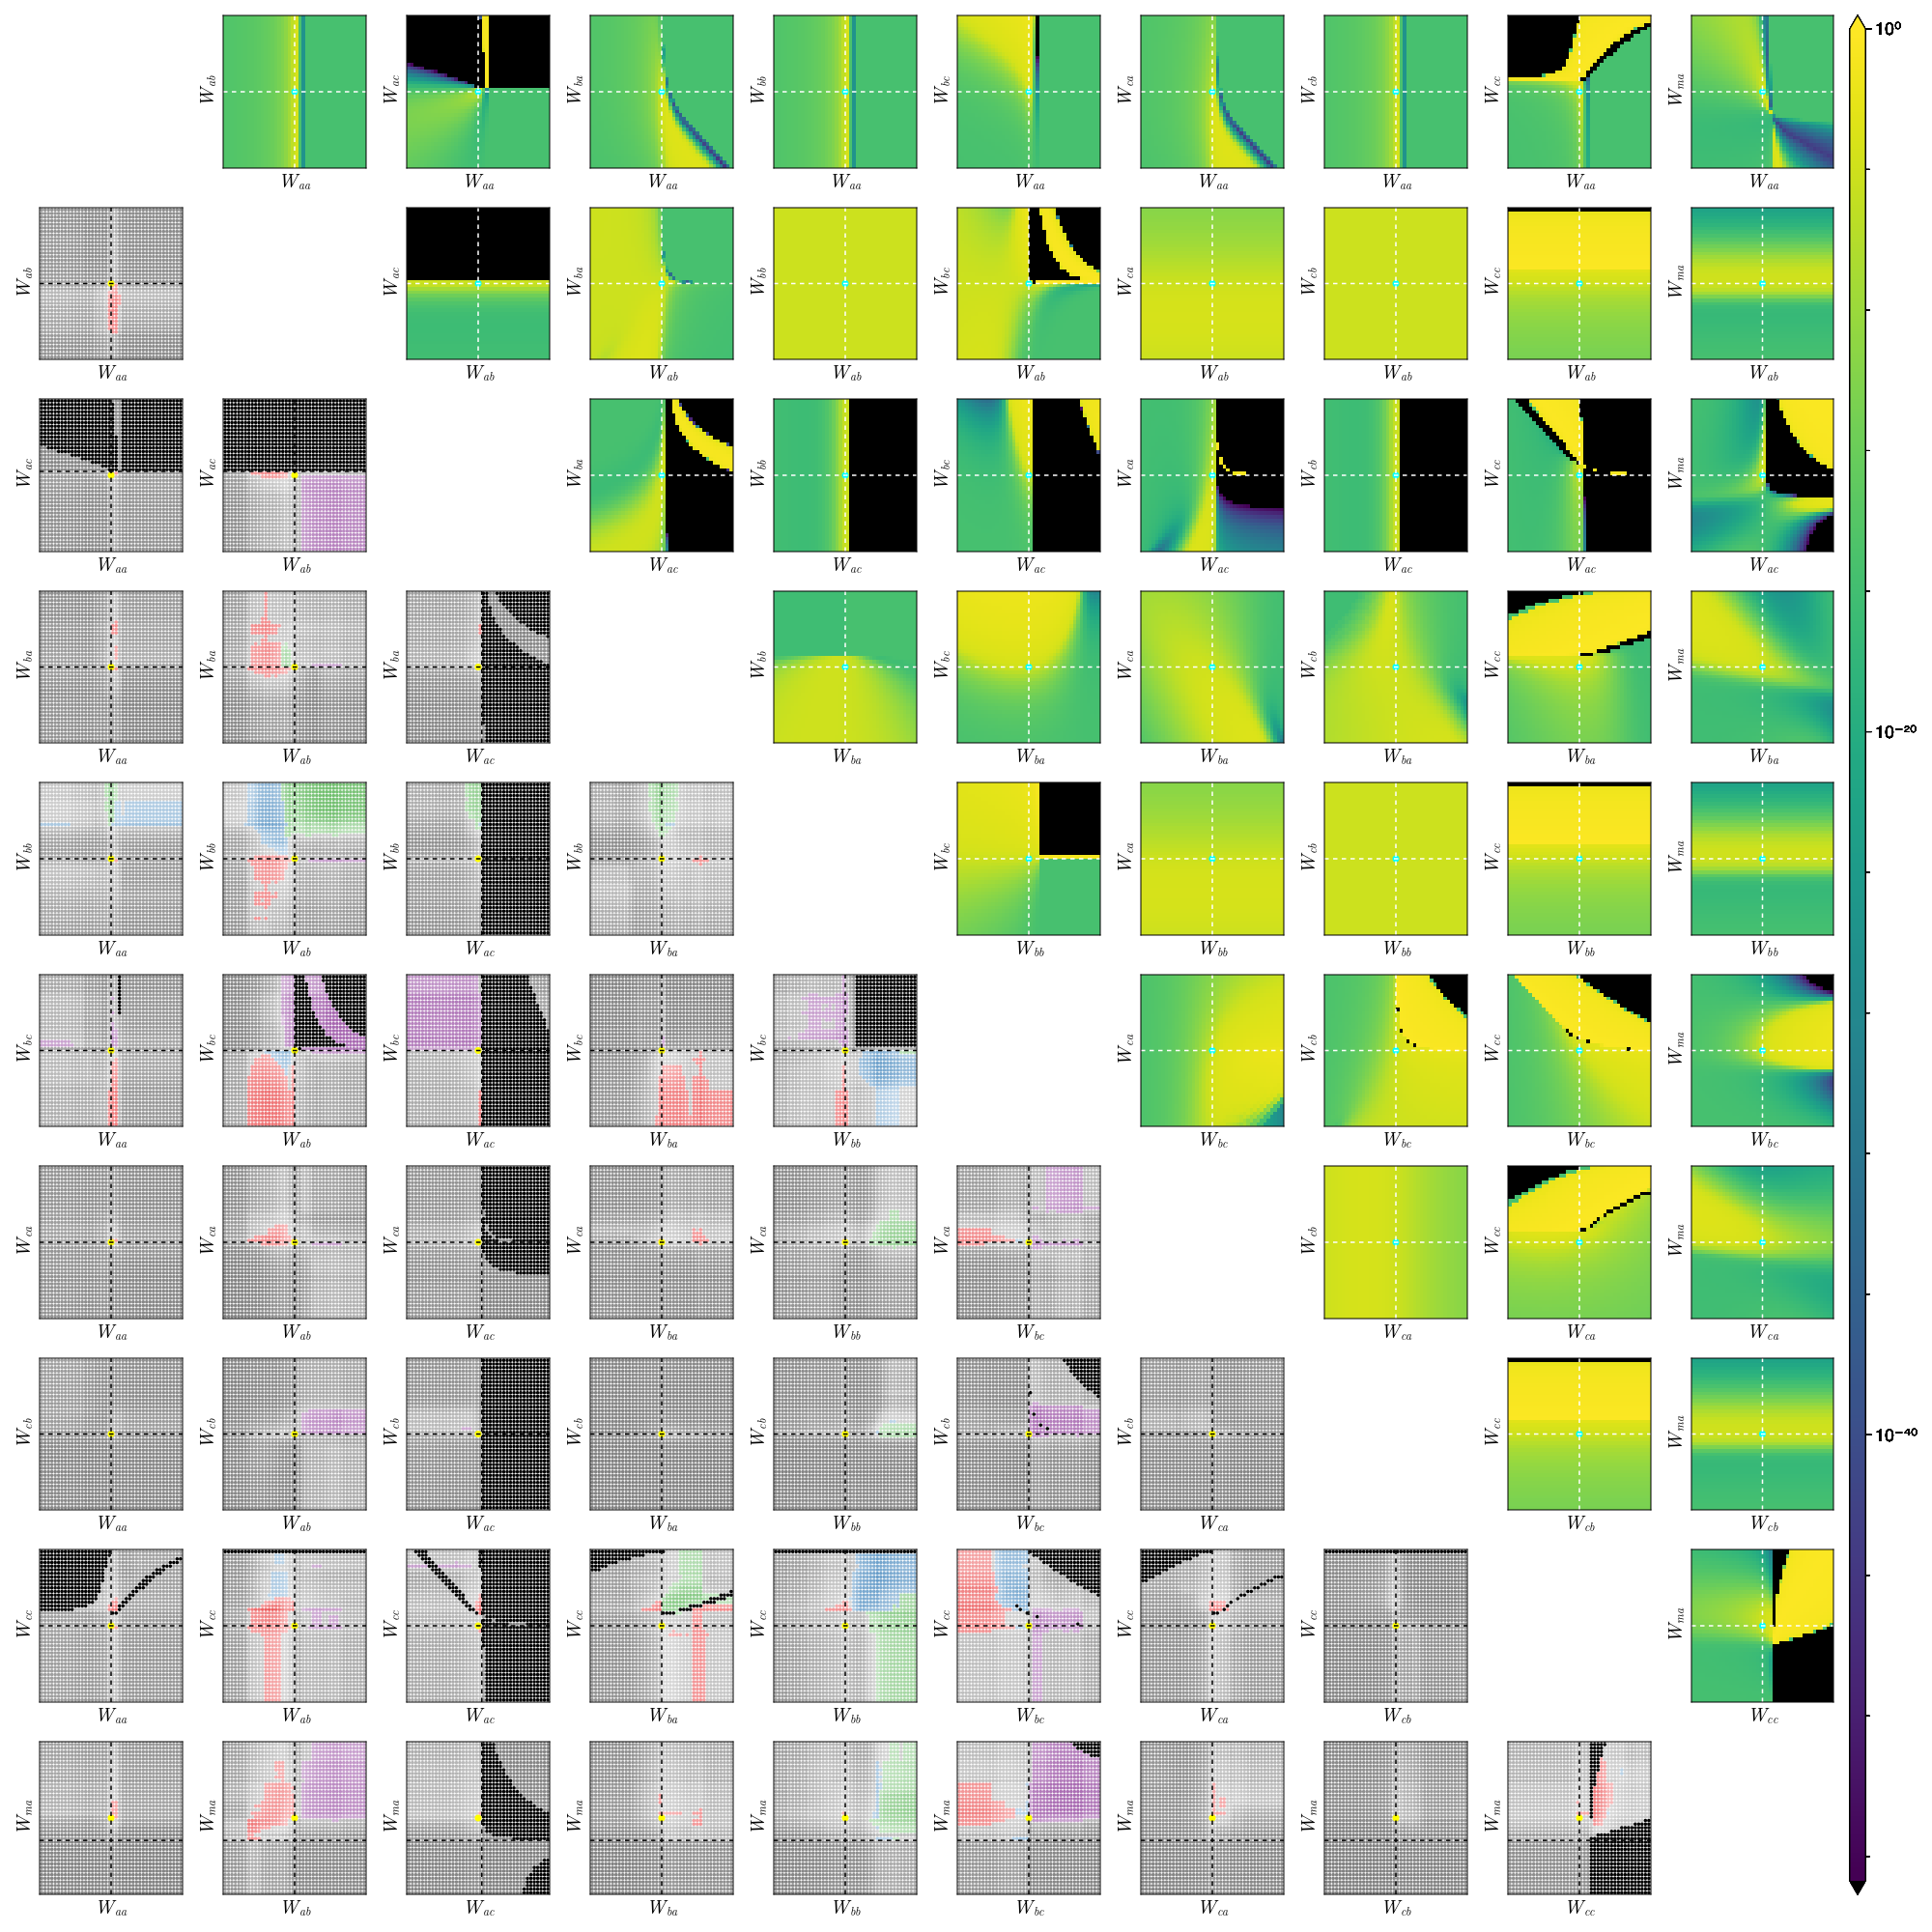

In [92]:
include(srcdirx("PredictionFitnessLandscapes.jl"))

fig = CairoMakie.Figure(resolution = (2000,2000),fontsize = 20)

start_network = [0.0 0.0 0.0 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.21577059555519695 0.0 0.0 0.0]

mut_q = 0.99999

plot_pairwise_fitness_landscape!(fig,test_indices,sample_points,founder,mut_q,mutation_op,fitness_grid,pred_grid,prob_grid,predict_colors)

cond_save(plotsdirx(plot_save_dir,"PairwiseFS_AllFitness.pdf"),fig,true)

fig

In [65]:
ex_s0_tr = trajectories_p[3]

ex_s0_network = reshape(ex_s0_tr.geno_traj[ex_s0_tr.H0-1],(3,4))

founder_s0 = Individual(reshape(ex_s0_network,(3,4)),grn_parameters,development);

In [66]:
fitness_grid_S0, stripe_ind_S0,mst_grid_S0 = create_pairwise_mst_fitness_landscape(founder_s0,development,test_indices,N_sample,sample_points)

# save("s0_grid_data.jld2", Dict("fitness" => fitness_grid_S0, "stripe"=>stripe_ind_S0,"mst"=>mst_grid_S0))

create_pairwise_mst_fitness_landscape (generic function with 1 method)

In [67]:
fitness_grid_s0 = load("s0_grid_data.jld2","fitness")
stripe_ind_s0 = load("s0_grid_data.jld2","stripe")
mst_grid_s0  = load("s0_grid_data.jld2","mst");

In [75]:
mst_label_grid_s0 = fill(0.,(10,10,N_sample*N_sample))

for (n1,t1) in enumerate(test_indices)
    for (n2,t2) in enumerate(test_indices)
        if n1 < n2
            mst_label_grid_s0[n1,n2,:] = mapslices(v->assign_mst_label(v,top_vertex_map,predict_id,vertex_to_predict_label),mst_grid_s0[n1,n2,:,:],dims = 2)
        end
    end
end

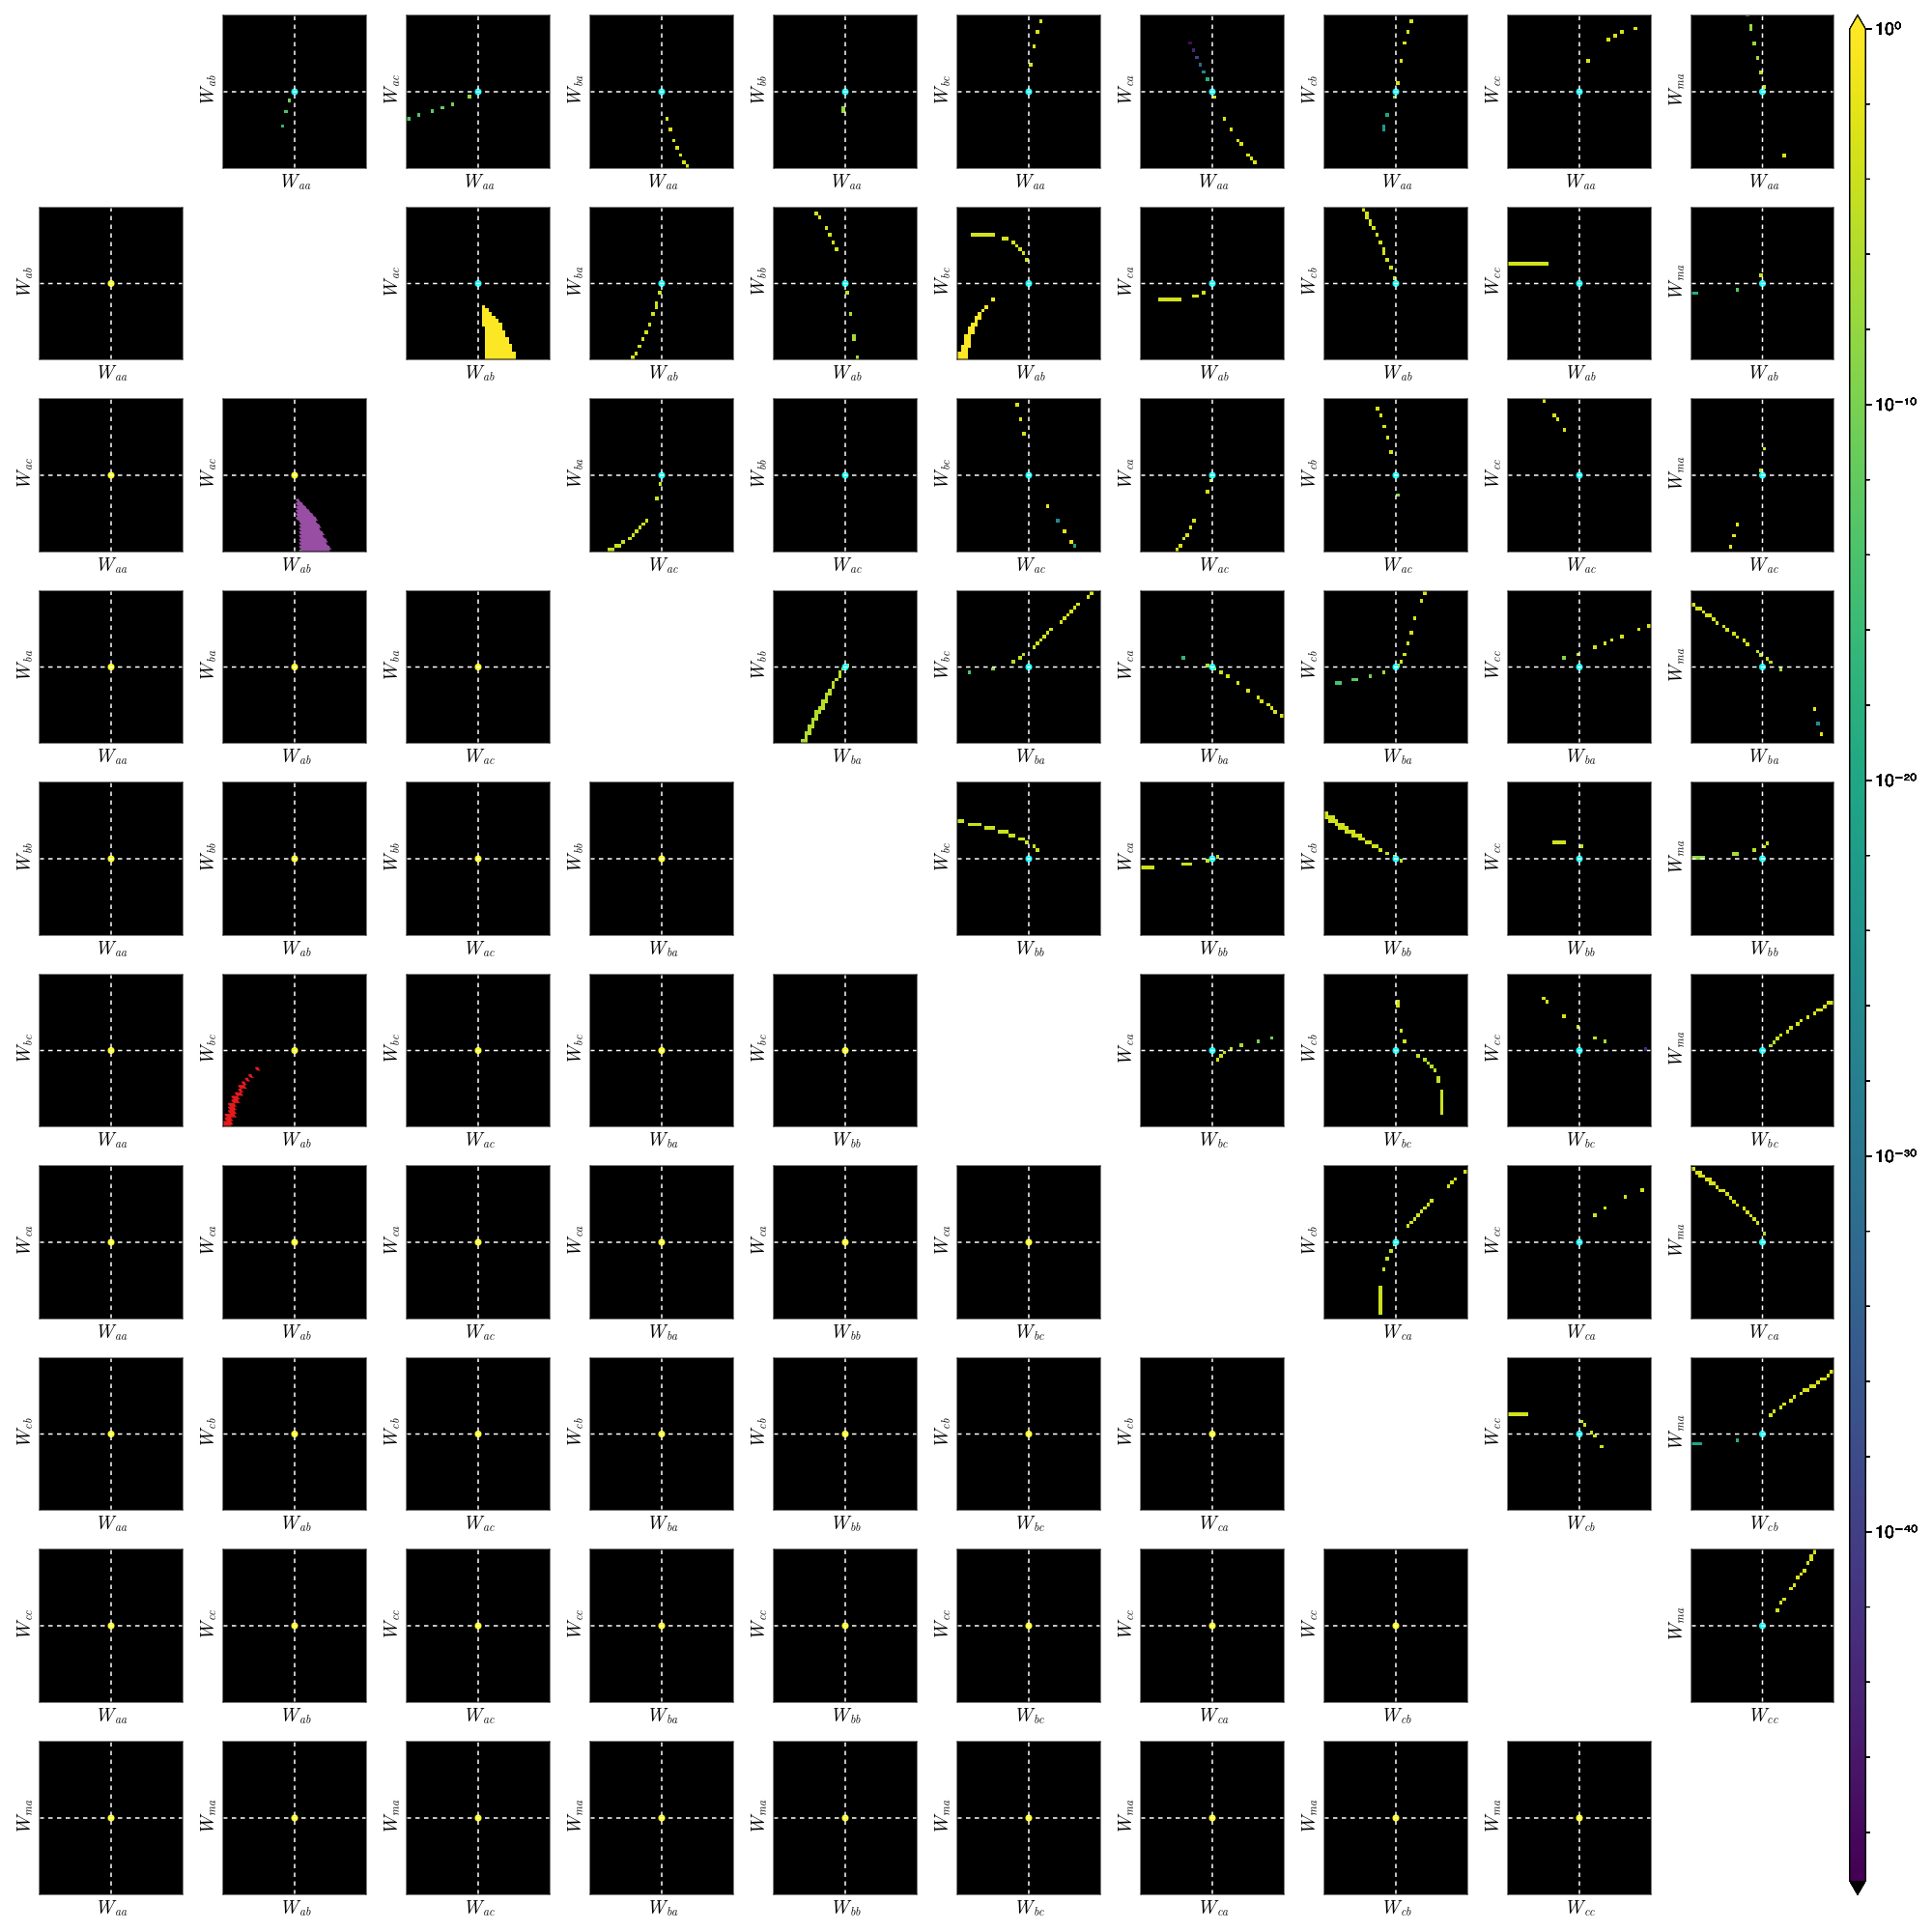

In [80]:
fig = CairoMakie.Figure(resolution = (2000,2000),fontsize = 20)

plot_mst_fitness_landscape!(fig,test_indices,sample_points,founder,mut_q,mutation_op,fitness_grid_s0 ,stripe_ind_s0 ,mst_grid_s0 ,mst_label_grid_s0,predict_colors)

cond_save(plotsdirx(plot_save_dir,"S0_PairwiseFS_AllFitness.pdf"),fig,true)

fig

In [1380]:
# all_target_networks = contingency_data["Double"][1]
# all_target_prob = contingency_data["Double"][2]
# vim_trajectories = contingency_data["Double"][3]
# all_target_ent_deltas = contingency_data["Double"][4]
# all_target_max_ent = contingency_data["Double"][5]

# fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
#     resolution = (1000,800),fontsize = fontsize_pub)

# plot_target_network_fitness_landscape!(fig,all_target_networks,top_n,founder,mut_q,mutation_op,fitness_grid)

# fig

In [1419]:
# fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
#     resolution = (460,150),fontsize = fontsize_pub)

# example_mst = 4

# # tr_choice = 66
# tr_choice = 9606

# fig_ex = fig[1,1] = GridLayout()

# create_example_traj_fig!(fig_ex,trajectories_p,sorted_uep,example_mst,tr_choice,ds_config_12,predict_colors,top_n)

# # findall(x->(x.H0 == 5), filter(tr->tr.inc_metagraph_vertices[tr.H0] ∈ sorted_uep[example_mst],trajectories_p))

# fig

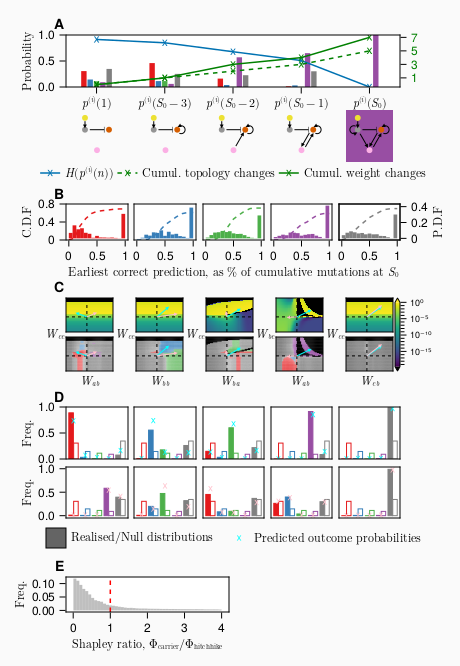

In [1497]:
include(srcdirx("AnalysisVisualization.jl"))

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (460,750-7*12),fontsize = fontsize_pub)

contin_target = [4,3,1,2,5]

mut_q = 0.99999

# all_target_networks = contingency_data["Double"][1]
# all_target_prob = contingency_data["Double"][2]
# vim_trajectories = contingency_data["Double"][3]


create_full_prediction_summary_epi!(fig,trajectories_p,sorted_uep,top_n,contingency_data,contin_choices,predict_label_to_vertex,vertex_to_predict_label,mut_q,fitness_eps,sample_points,predict_colors,fs12_default,evo_config_12,ds_config_12,fontsize_pub)

cond_save(plotsdirx(plot_save_dir,"Fig4_prediction2.pdf"),fig,true)

# should add error bars to realised distributions
# for realised based on first mut and then prediction - we should be able to make prediction based on how beta changes to Inf. 
# probability weighted entropy of first mutation as a measure of systems constraint at first mutation 

fig

In [174]:
first_pred_prob_test = reduce(hcat,map(tr->tr.gt_label_probabilities[2,:],trajectories_p[test_id])) |> transpose |> collect
first_pred_prob_train = reduce(hcat,map(tr->tr.gt_label_probabilities[2,:],trajectories_p[train_id])) |> transpose |> collect;

first_pred_prob_all = reduce(hcat,map(tr->tr.gt_label_probabilities[2,:],trajectories_p)) |> transpose |> collect;

In [ ]:
length(trajectories_p) == length(test_id) + length(train_id)

In [ ]:
confint(BinomialTest(8, 10))

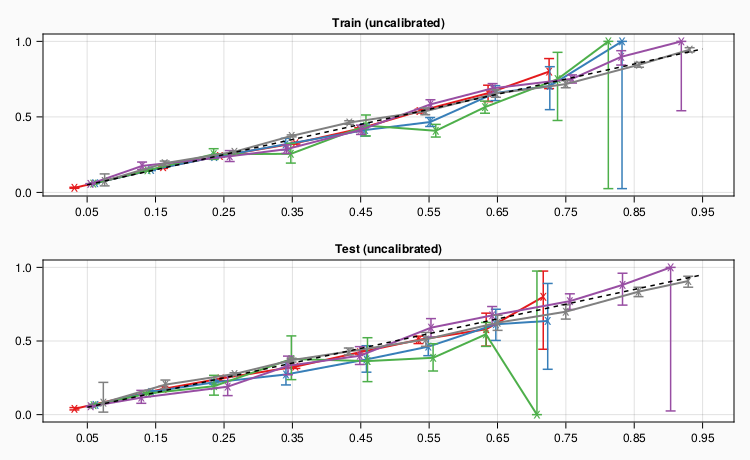

In [175]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (750,460),fontsize = fontsize_pub)
    
include(srcdirx("PredictionAnalytics.jl"))

produce_prob_calibration_curve_binomial!(fig,labels[train_id],first_pred_prob_train,labels[test_id],first_pred_prob_test,predict_colors)

fig

In [ ]:
# fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
#     resolution = (460,110),fontsize = fontsize_pub)

# fig_hist = fig[1,1] = GridLayout()
# fig_pie = fig[1,2] = GridLayout()

# ax = Axis(fig_hist[1,1])

# traj_epi_pop = filter(tr->(length(tr.mutant_info[1].weight_id) == 3) & (tr.gt_label_predictions[2] .!= -1),trajectories_p)

# all_first_entropies = map(tr->tr.gt_label_entropies[2],traj_epi_pop)

# all_first_pred = [tr.gt_label_predictions[2] == -1 ? 5 : vertex_to_predict_label[tr.gt_label_predictions[2]] for tr in traj_epi_pop]

# first_epi = map(tr->tr.epistasis[2],traj_epi_pop)

# CairoMakie.hist!(ax,all_first_entropies,bins = 50,color = (:grey,0.5))

# bin_boundaries = [0.6,0.65,0.7]

# CairoMakie.vlines!(bin_boundaries,linestyle = :dash, color = :black)

# # h_first_ent = fit(Histogram, all_first_entropies, bin_boundaries; closed = :left) 

# h_first_ent = fit(Histogram, all_first_entropies, bin_boundaries; closed = :left) 

# first_ent_bins = map(f->StatsBase.binindex(h_first_ent, f),all_first_entropies);

# for i in 0:length(bin_boundaries)

#     ax_pred = Axis(fig_pie[1,i+1]) 
#     # ax_epi = Axis(fig_pie[2,i+1]) 

#     pred_prop = calculate_pred_proportion(all_first_pred[first_ent_bins .== i])

#     CairoMakie.pie!(ax_pred,pred_prop,radius = evo_config_12.pie_radius,color = predict_colors,
#     inner_radius = evo_config_12.pie_inner_radius,
#     strokecolor = :white,
#     strokewidth = evo_config_12.pie_strokewidth)

#     # CairoMakie.pie!(ax_epi,epi_prop,radius = evo_config_12.pie_radius,color = evo_config_12.pie_colors,
#     # inner_radius = evo_config_12.pie_inner_radius,
#     # strokecolor = :white,
#     # strokewidth = evo_config_12.pie_strokewidth)

#     CairoMakie.hidedecorations!(ax_pred)
#     # CairoMakie.hidedecorations!(ax_epi)
# end

# rowgap!(fig_hist, Relative(0.02))
# colgap!(fig_hist, Relative(0.02))

# rowgap!(fig_pie, Relative(0.02))
# colgap!(fig_pie, Relative(0.02))

# rowgap!(fig.layout, Relative(0.02))
# colgap!(fig.layout, Relative(0.02))

# fig

In [ ]:
h_first_ent = fit(Histogram, all_first_entropies, bin_boundaries; closed = :left) 

first_ent_bins = map(f->StatsBase.binindex(h_first_ent, f),all_first_entropies);

function calculate_pred_proportion(preds)
    
    total = length(preds)

    return [count(x->x==p,preds)/total for p in [1,2,3,4,5]]
end

In [ ]:
calculate_pred_proportion(all_first_pred[first_ent_bins .== 2])

In [ ]:
countmap(first_epi[first_ent_bins .== 1])

In [ ]:
countmap(first_epi[first_ent_bins .== 2])

In [ ]:
# [0.0 0.0 0.0 1.2490335893436255; 3.333333333333332 0.0 0.0 0.0; -0.21577059555519695 0.0 -0.9090909090909092 0.0]
# [0.0 0.0 0.0 1.2490335893436255; 0.0 3.737373737373737 0.0 0.0; -0.21577059555519695 0.0 0.9090909090909083 0.0]
# [0.0 -0.30303030303030276 0.0 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.21577059555519695 0.0 0.9090909090909083 0.0]
# [0.0 0.0 0.0 1.2490335893436255; -0.7070707070707076 0.0 0.0 0.0; -0.21577059555519695 -0.10101010101010033 0.0 0.0]
# [0.0 0.0 0.0 1.2490335893436255; 0.0 0.0 2.929292929292931 0.0; -0.21577059555519695 0.0 2.525252525252526 0.0]

contin_choices

In [ ]:
contin_prob[end]

In [ ]:
vim_trajectories = contingency_data["Single"][1]

vim_trajectories[2][2].geno_traj

In [ ]:
# associate incorrect predictions with "rarer trajectories" consisting of non-typical mutations
# explain final distribution of outcomes by monte carlo on initial mutation

In [ ]:
incorrect_test = test_id[streak .== 1]
correct_test = test_id[streak .!= 1];

In [ ]:
incorrect_ent = map(tr->minimum(tr.gt_label_entropies),trajectories_p[incorrect_test])
correct_ent = map(tr->minimum(tr.gt_label_entropies),trajectories_p[correct_test]);

In [ ]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1000,500),fontsize = fontsize_pub)

ax = Axis(fig[1,n], ylabel =  "Frequency",title = "Correct")
ax2 = Axis(fig[2,n],ylabel =  "Frequency",title = "Incorrect")

CairoMakie.hist!(ax,correct_ent)
CairoMakie.hist!(ax2,incorrect_ent)

fig

In [ ]:
incorrect_mut = map(tr->tr.mutant_info,trajectories_p[incorrect_test])
correct_mut = map(tr->tr.mutant_info,trajectories_p[correct_test]);

In [ ]:
icm_size = reduce(vcat,reduce(vcat,map(ml->map(m->m.mut_size,ml),incorrect_mut)))
cm_size = reduce(vcat,reduce(vcat,map(ml->map(m->m.mut_size,ml),correct_mut)));

icm_fd = reduce(vcat,reduce(vcat,map(ml->map(m->m.fitness_delta,ml),incorrect_mut)))
cm_fd = reduce(vcat,reduce(vcat,map(ml->map(m->m.fitness_delta,ml),correct_mut)));

icm_nmut = reduce(vcat,reduce(vcat,map(ml->map(m->length(m.mut_size),ml),incorrect_mut)))
cm_nmut = reduce(vcat,reduce(vcat,map(ml->map(m->length(m.mut_size),ml),correct_mut)));

In [ ]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1000,500),fontsize = fontsize_pub)

titles = ["Mutation size","FItness Deltas", "N_Mutations"]

for (n,d) in enumerate([[icm_size,cm_size],[icm_fd,cm_fd],[icm_nmut,cm_nmut]])

    ax = Axis(fig[1,n], ylabel =  "Frequency",title = "Correct: " * titles[n])
    ax2 = Axis(fig[2,n],ylabel =  "Frequency",title = "Incorrect: " * titles[n])

    CairoMakie.hist!(ax,d[2])
    CairoMakie.hist!(ax2,d[1])

end

cond_save(plotsdirx(plot_save_dir,"WrongPred.pdf"),fig,true)

fig

In [ ]:
all_w = []

for _ in 1:1e5

    mutant,m_choices,m_type,m_sizes,m_valid = create_mutant(founder,mutate_function,development)
    
    if m_valid && SciMLBase.successful_retcode(mutant.phenotype.retcode)

        mutant_fitness = fitness_function(mutant.phenotype)
    
        if rand() < fixation_probability_kim(mutant_fitness[1] - founder_fitness[1],mutant_fitness[2] - founder_fitness[2],β[1],10)
            push!(all_w,vec(mutant.genotype.p[1]))
        end

    end
    
end

In [ ]:
start_v = reduce(hcat,all_w)[1:10,:]

gt_dtrain = xgboost.DMatrix(start_v |> transpose |> collect, feature_names = weight_names)
gt_label_probabilities = model_gtl.predict(gt_dtrain)
gt_label_predictions = mapslices(p->argmax(p),gt_label_probabilities,dims = 2)
gt_label_entropies = mapslices(p->entropy(p),gt_label_probabilities,dims = 2);

initial_dist_s =  mapslices(p->StatsBase.sample([1,2,3,4,5], Weights(p), 1),gt_label_probabilities,dims =2)

initial_dist = [count(i->i==n,initial_dist_s)/length(initial_dist_s) for n in 1:5]

In [ ]:
null_H0_dist

In [ ]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (460,200),fontsize = fontsize_pub)

ax = Axis(fig[1,1],xlabel = L"\text{Prediction labels}", ylabel =  "Frequency")

CairoMakie.barplot!(ax,[1,2,3,4,5],initial_dist, color = predict_colors[1:5])
CairoMakie.scatter!(ax,[1,2,3,4,5],null_H0_dist, color = :cyan)

ax.xticks = (1:5,[L"\text{MST:1}",L"\text{MST:2}",L"\text{MST:3}",L"\text{MST:4}",L"\text{MST:Other}"])

cond_save(plotsdirx(plot_save_dir,"MC_NullH0Dist.pdf"),fig,true)

fig

In [ ]:
all_w_inf = []

for _ in 1:1e5

    mutant,m_choices,m_type,m_sizes,m_valid = create_mutant(founder,mutate_function,development)
    
    if m_valid && SciMLBase.successful_retcode(mutant.phenotype.retcode)

        mutant_fitness = fitness_function(mutant.phenotype)
    
        if rand() < fixation_probability_kim(mutant_fitness[1] - founder_fitness[1],mutant_fitness[2] - founder_fitness[2],0.1,β[2])
            push!(all_w_inf,vec(mutant.genotype.p[1]))
        end

    end
    
end

In [ ]:
start_v = reduce(hcat,all_w_inf)[1:10,:]

gt_dtrain = xgboost.DMatrix(start_v |> transpose |> collect, feature_names = weight_names)
gt_label_probabilities = model_gtl.predict(gt_dtrain)
gt_label_predictions = mapslices(p->argmax(p),gt_label_probabilities,dims = 2)
gt_label_entropies = mapslices(p->entropy(p),gt_label_probabilities,dims = 2);

initial_dist_s =  mapslices(p->StatsBase.sample([1,2,3,4,5], Weights(p), 1),gt_label_probabilities,dims =2)

initial_dist = [count(i->i==n,initial_dist_s)/length(initial_dist_s) for n in 1:5]

In [ ]:
mean(gt_label_entropies)

In [ ]:
# ability to predict trajectory outcomes individually
# ability to learn fitness landscape
# behaviour of whol ensembles

In [ ]:
function simulate_batch_fm(n,founder,mutate_function,development)

    all_w = []

    for _ in 1:n

        mutant,m_choices,m_type,m_sizes,m_valid = create_mutant(founder,mutate_function,development)
        
        if m_valid && SciMLBase.successful_retcode(mutant.phenotype.retcode)

            mutant_fitness = fitness_function(mutant.phenotype)
        
            if rand() < fixation_probability_kim(mutant_fitness[1] - founder_fitness[1],mutant_fitness[2] - founder_fitness[2],β[1],β[2])
                push!(all_w,vec(mutant.genotype.p[1]))
            end

        end
        
    end

    filter!(x->typeof(x)==Vector,all_w)

    return all_w
end

In [ ]:
all_w_b = pmap(s->simulate_batch_fm(1e5,founder,mutate_function,development),1:5)

In [ ]:
start_v = reduce(hcat,all_w)[1:10,:]

gt_dtrain = xgboost.DMatrix(start_v |> transpose |> collect, feature_names = weight_names)
gt_label_probabilities = model_gtl.predict(gt_dtrain)
gt_label_predictions = mapslices(p->argmax(p),gt_label_probabilities,dims = 2)
gt_label_entropies = mapslices(p->entropy(p),gt_label_probabilities,dims = 2);

In [ ]:
initial_dist = [count(i->i==n,gt_label_predictions)/length(gt_label_predictions) for n in 1:5]

In [ ]:
initial_dist_s =  mapslices(p->StatsBase.sample([1,2,3,4,5], Weights(p), 1),gt_label_probabilities,dims =2)

initial_dist = [count(i->i==n,initial_dist_s)/length(initial_dist_s) for n in 1:5]

In [ ]:
null_H0_dist